In [1]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

['.ipynb_checkpoints', 'data_description.txt', 'kernel.ipynb', 'sample_submission.csv', 'score.csv', 'test.csv', 'train.csv']


In [2]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# load data
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Test data is missing the SalePrice column which is our dependent variable, this column is what our test predictions will test against when scoring on kaggle

In [6]:
# check dtypes and nulls
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [7]:
# check if Id column is a unique identifier and if so set it as index
len(df_train.Id.value_counts()), len(df_test.Id.value_counts())

(1460, 1459)

In [8]:
df_train = df_train.set_index('Id')
df_test = df_test.set_index('Id')

### Next, I'll remove outliers as specified in http://jse.amstat.org/v19n3/decock.pdf in the potential pitfall section, observations with GRLIVAREA greater than 4000 sqft

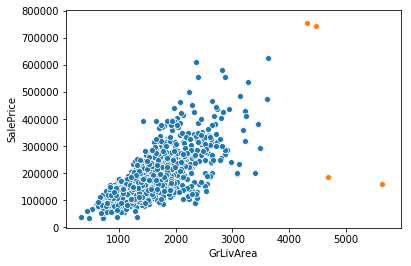

In [9]:
# plot grlivarea vs saleprice, remove orange dots
sns.scatterplot(df_train.GrLivArea, df_train.SalePrice)
sns.scatterplot(df_train.GrLivArea[df_train.GrLivArea > 4000], df_train.SalePrice);

In [10]:
df_train = df_train[df_train.GrLivArea < 4000]
df_train.shape

(1456, 80)

In [11]:
# add all data together to start eda and feature selection & engineering
data = pd.concat((df_train, df_test), sort=False)
data.shape

(2915, 80)

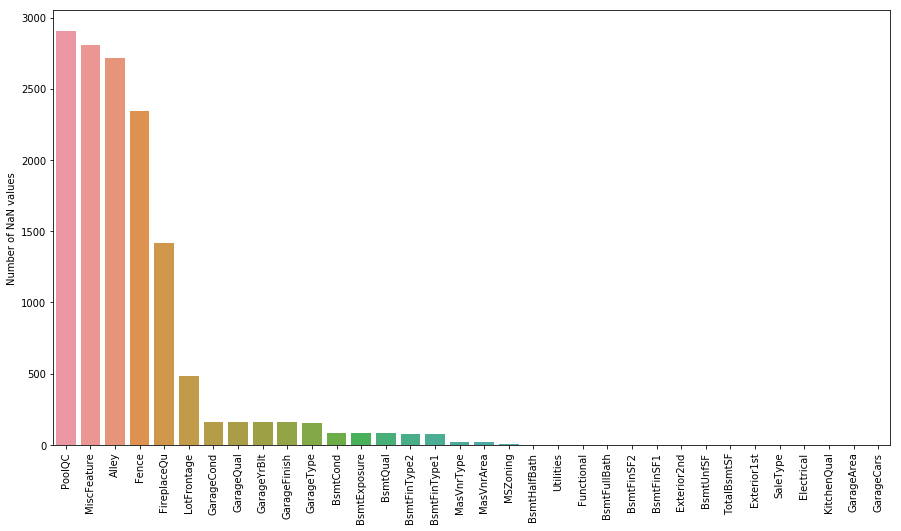

In [12]:
# check null values
null_totals = data.drop('SalePrice', axis=1).isnull().sum().sort_values(ascending=False)
null_totals = null_totals[null_totals != 0]
plt.figure(figsize=(15,8))
sns.barplot(null_totals.index, null_totals)
plt.xticks(rotation=90)
plt.gca().set_ylabel('Number of NaN values');

In [13]:
# lets investigate missing values and try to fill them
# will define a function to plot distribution and probplot
def dist_and_prob(x):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    sns.distplot(x, fit=stats.norm, ax=ax[0])
    stats.probplot(x, plot=ax[1])
    ax[0].legend(['Skew = ' + str(x.skew().round(2)) + ' mean = ' + str(round(x.mean(), 2)) + ' std = ' + str(round(x.std(), 2))],
                 loc='best', handlelength=0, handletextpad=0, fancybox=True)

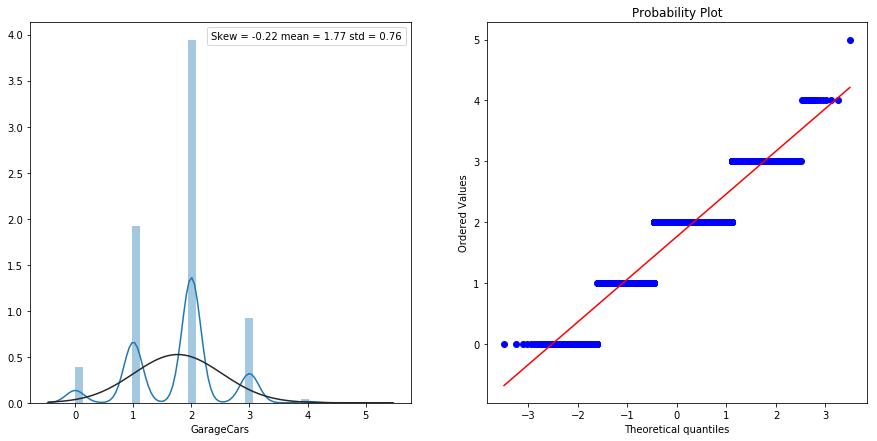

In [14]:
dist_and_prob(data.GarageCars.dropna())

In [15]:
garage_columns = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars']
data[data.GarageCars.isnull()][garage_columns]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars
Id,,,,,
2577,Detchd,NaN,NaN,NaN,NaN


In [16]:
# garagecars has one missing entry we'll assume to be 0 because most columns point us to no garage and we'll change type to None
data.loc[2577, 'GarageType'] = 'None'
data.GarageCars.fillna(0, inplace=True)
data.GarageCars.isnull().sum()

0

In [17]:
# same entry as above
data[data.GarageArea.isnull()][garage_columns]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars
Id,,,,,
2577,None,NaN,NaN,NaN,0.0


In [18]:
data.GarageArea.fillna(0, inplace=True)
data.GarageArea.isnull().sum()

0

In [19]:
# kitchenQual
data[data.KitchenQual.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1556,50,RL,72.0,10632,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2010,COD,Normal,NaN


In [20]:
data.KitchenQual.value_counts()

TA    1492
Gd    1151
Ex     201
Fa      70
Name: KitchenQual, dtype: int64

In [21]:
# fill with mode TA which means typical average
data.KitchenQual.fillna(data.KitchenQual.mode()[0], inplace=True)
data.KitchenQual.isnull().sum()

0

In [22]:
# Electrical
data[data.Electrical.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500.0


In [23]:
data.Electrical.value_counts()

SBrkr    2667
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [24]:
# fill with mode
data.Electrical.fillna(data.Electrical.mode()[0], inplace=True)
data.Electrical.isnull().sum()

0

In [25]:
# SaleType
data[data.SaleType.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2490,20,RL,85.0,13770,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,10,2007,NaN,Normal,NaN


In [26]:
data.SaleType.value_counts()

WD       2523
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [27]:
# fill with mode
data.SaleType.fillna(data.SaleType.mode()[0], inplace=True)
data.SaleType.isnull().sum()

0

In [28]:
# Exterior1st
data[data.Exterior1st.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2152,30,RL,85.0,19550,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,NaN


In [29]:
data.Exterior1st.value_counts()

VinylSd    1025
MetalSd     450
HdBoard     441
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
Stone         2
AsphShn       2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64

In [30]:
# fill with mode
data.Exterior1st.fillna(data.Exterior1st.mode()[0], inplace=True)
data.Exterior1st.isnull().sum()

0

In [31]:
bsmt_columns = data.columns[data.columns.str.contains('Bsmt')]
bsmt_columns

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

In [32]:
# totalbsmtsf
data[data.TotalBsmtSF.isnull()][bsmt_columns]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# since columns NaN, we'll assume 0 bsmt
data.TotalBsmtSF.fillna(0, inplace=True)
data.TotalBsmtSF.isnull().sum()

0

In [34]:
# fill other bsmt sf values with 0
data.BsmtUnfSF.fillna(0, inplace=True)
data.BsmtFinSF1.fillna(0, inplace=True)
data.BsmtFinSF2.fillna(0, inplace=True)

In [35]:
# exterior2nd
data[data.Exterior2nd.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2152,30,RL,85.0,19550,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,NaN


In [36]:
data.Exterior2nd.value_counts()

VinylSd    1014
MetalSd     447
HdBoard     405
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      14
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

In [37]:
# fill with mode
data.Exterior2nd.fillna(data.Exterior2nd.mode()[0], inplace=True)

In [38]:
# Bsmtfullbath, Bsmthalfbath
data[data.BsmtFullBath.isnull()][bsmt_columns]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2121,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN
2189,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [39]:
data.BsmtFullBath.value_counts()

0.0    1704
1.0    1170
2.0      37
3.0       2
Name: BsmtFullBath, dtype: int64

In [40]:
# fill with 0
data.BsmtFullBath.fillna(0, inplace=True)
data.BsmtHalfBath.fillna(0, inplace=True)

In [41]:
# Functional
data[data.Functional.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
2217,20,NaN,80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml,NaN
2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,9,2007,COD,Abnorml,NaN


In [42]:
data.Functional.value_counts()

Typ     2713
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [43]:
# fill with mode
data.Functional.fillna(data.Functional.mode()[0], inplace=True)

In [44]:
# Utilities
data[data.Utilities.isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1916,30,NaN,109.0,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,...,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal,NaN
1946,20,RL,NaN,31220,Pave,NaN,IR1,Bnk,NaN,FR2,...,0,NaN,NaN,Shed,750,5,2008,WD,Normal,NaN


In [45]:
data.Utilities.value_counts()

AllPub    2912
NoSeWa       1
Name: Utilities, dtype: int64

In [46]:
# since all observations are the same type, will drop the whole column
data.drop('Utilities', axis=1, inplace=True)

In [47]:
# mszoning
data[data.MSZoning.isnull()]['Neighborhood']

Id
1916     IDOTRR
2217     IDOTRR
2251     IDOTRR
2905    Mitchel
Name: Neighborhood, dtype: object

In [48]:
data.groupby('Neighborhood').MSZoning.value_counts()

Neighborhood  MSZoning
Blmngtn       RL           25
              RM            3
Blueste       RM           10
BrDale        RM           30
BrkSide       RM           65
              RL           43
ClearCr       RL           44
CollgCr       RL          253
              RM           14
Crawfor       RL           91
              RM           10
              RH            2
Edwards       RL          178
              RM           12
              RH            2
Gilbert       RL          165
IDOTRR        RM           68
              C (all)      22
MeadowV       RM           37
Mitchel       RL          104
              RM            9
NAmes         RL          436
              RH            7
NPkVill       RL           23
NWAmes        RL          131
NoRidge       RL           69
NridgHt       RL          165
              RM            1
OldTown       RM          198
              RL           39
              C (all)       2
SWISU         RL           38
              RH 

In [49]:
data.MSZoning.value_counts()

RL         2261
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [50]:
# will fill the IDOTRR neighborhood properties with RM because no RL in that neighborhood. RL for the mitchel property
nullzones = data[data.MSZoning.isnull()]['Neighborhood']
indexed = nullzones[nullzones == 'IDOTRR'].index
data.loc[indexed, 'MSZoning'] = data.loc[indexed, 'MSZoning'].fillna('RM')
data.MSZoning.fillna('RL', inplace=True)

In [51]:
# MassVnrArea, MassVnrType
data[data.MasVnrArea.isnull()][['MasVnrArea', 'MasVnrType']]

,MasVnrArea,MasVnrType
Id,,
235,NaN,NaN
530,NaN,NaN
651,NaN,NaN
937,NaN,NaN
974,NaN,NaN
978,NaN,NaN
1244,NaN,NaN
1279,NaN,NaN
1692,NaN,NaN


In [52]:
data.MasVnrType.value_counts()

None       1741
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

In [53]:
# fill type with None and area with 0
data.MasVnrType.fillna('None', inplace=True)

In [54]:
data.MasVnrArea.fillna(0, inplace=True)

In [55]:
data.MasVnrType.isnull().sum()

0

In [56]:
# BsmtFinType1, BsmtFinType2
data[data.BsmtFinType1.isnull()][bsmt_columns]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
18,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
40,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
91,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
103,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
157,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
183,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
260,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
343,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
363,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [57]:
# fill both with None since no basement
data.BsmtFinType1.fillna('None', inplace=True)
data.BsmtFinType2.fillna('None', inplace=True)

In [58]:
data.BsmtFinType2.isnull().sum()

0

In [59]:
# BsmtQual, BsmtCond, BsmtExposure
data[data.BsmtQual.isnull()][bsmt_columns]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
18,NaN,NaN,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
40,NaN,NaN,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
91,NaN,NaN,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
103,NaN,NaN,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
157,NaN,NaN,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
183,NaN,NaN,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
260,NaN,NaN,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
343,NaN,NaN,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
363,NaN,NaN,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0


In [60]:
# fill with None except 2218, 2219 mode
data.loc[[2218,2219],'BsmtQual'] = data.loc[[2218,2219],'BsmtQual'].transform(lambda x: data.BsmtQual.mode()[0])
data.BsmtQual.fillna('None', inplace=True)
data.BsmtQual.value_counts()

TA      1285
Gd      1209
Ex       254
Fa        88
None      79
Name: BsmtQual, dtype: int64

In [61]:
null_bsmt_cond = data[data.BsmtCond.isnull()][bsmt_columns]
indexes = null_bsmt_cond[null_bsmt_cond.TotalBsmtSF != 0].index
null_bsmt_cond[null_bsmt_cond.TotalBsmtSF != 0]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2041,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
2186,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
2525,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


In [62]:
# will fill these 3 cases with mode and the rest with None
data.loc[indexes, 'BsmtCond'] = data.loc[indexes, 'BsmtCond'].fillna(data.BsmtCond.mode()[0])
data.BsmtCond.fillna('None', inplace=True)
data.BsmtCond.value_counts()

TA      2605
Gd       122
Fa       104
None      79
Po         5
Name: BsmtCond, dtype: int64

In [63]:
data[data.BsmtExposure.isnull()][bsmt_columns]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
18,None,None,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
40,None,None,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
91,None,None,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
103,None,None,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
157,None,None,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
183,None,None,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
260,None,None,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
343,None,None,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0
363,None,None,NaN,None,0.0,None,0.0,0.0,0.0,0.0,0.0


In [64]:
null_bsmt_exp = data[data.BsmtExposure.isnull()][bsmt_columns]
indexes = null_bsmt_exp[null_bsmt_exp.TotalBsmtSF != 0].index
null_bsmt_exp[null_bsmt_exp.TotalBsmtSF != 0]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
949,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0
1488,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
2349,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0


In [65]:
# fill 3 with mode and rest None
data.loc[indexes, 'BsmtExposure'] = data.loc[indexes, 'BsmtExposure'].fillna(data.BsmtExposure.mode()[0])
data.BsmtExposure.fillna('None', inplace=True)
data.BsmtExposure.value_counts()

No      1907
Av       417
Gd       273
Mn       239
None      79
Name: BsmtExposure, dtype: int64

In [66]:
# garage columns
data[data.GarageType.isnull()][garage_columns]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars
Id,,,,,
40,NaN,NaN,NaN,NaN,0.0
49,NaN,NaN,NaN,NaN,0.0
79,NaN,NaN,NaN,NaN,0.0
89,NaN,NaN,NaN,NaN,0.0
90,NaN,NaN,NaN,NaN,0.0
100,NaN,NaN,NaN,NaN,0.0
109,NaN,NaN,NaN,NaN,0.0
126,NaN,NaN,NaN,NaN,0.0
128,NaN,NaN,NaN,NaN,0.0


In [67]:
# fill with none
data.GarageType.fillna('None', inplace=True)
data.GarageType.value_counts()

Attchd     1720
Detchd      778
BuiltIn     185
None        158
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64

In [68]:
null_garage = data[data.GarageFinish.isnull()]
indexes = null_garage[null_garage.GarageType != 'None'].index
null_garage[null_garage.GarageType != 'None'][garage_columns]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars
Id,,,,,
2127,Detchd,NaN,NaN,NaN,1.0


In [69]:
# fill with mode for the 2 above
data.loc[indexes, 'GarageFinish'] = data.loc[indexes, 'GarageFinish'].fillna(data.GarageFinish.mode()[0])
data.loc[indexes, 'GarageQual'] = data.loc[indexes, 'GarageQual'].fillna(data.GarageQual.mode()[0])
data.loc[indexes, 'GarageCond'] = data.loc[indexes, 'GarageCond'].fillna(data.GarageCond.mode()[0])
data.GarageFinish.fillna('None', inplace=True)
data.GarageFinish.value_counts()

Unf     1231
RFn      811
Fin      715
None     158
Name: GarageFinish, dtype: int64

In [70]:
data[data.GarageQual.isnull()][garage_columns]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars
Id,,,,,
40,None,None,NaN,NaN,0.0
49,None,None,NaN,NaN,0.0
79,None,None,NaN,NaN,0.0
89,None,None,NaN,NaN,0.0
90,None,None,NaN,NaN,0.0
100,None,None,NaN,NaN,0.0
109,None,None,NaN,NaN,0.0
126,None,None,NaN,NaN,0.0
128,None,None,NaN,NaN,0.0


In [71]:
data.GarageQual.fillna('None', inplace=True)
data.GarageQual.value_counts()

TA      2601
None     158
Fa       124
Gd        24
Po         5
Ex         3
Name: GarageQual, dtype: int64

In [72]:
data[data.GarageCond.isnull()][garage_columns]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars
Id,,,,,
40,None,None,None,NaN,0.0
49,None,None,None,NaN,0.0
79,None,None,None,NaN,0.0
89,None,None,None,NaN,0.0
90,None,None,None,NaN,0.0
100,None,None,None,NaN,0.0
109,None,None,None,NaN,0.0
126,None,None,None,NaN,0.0
128,None,None,None,NaN,0.0


In [73]:
data.GarageCond.fillna('None', inplace=True)
data.GarageCond.value_counts()

TA      2651
None     158
Fa        74
Gd        15
Po        14
Ex         3
Name: GarageCond, dtype: int64

In [74]:
data[data.GarageYrBlt.isnull()][garage_columns + ['GarageYrBlt', 'YearBuilt', 'Neighborhood']][data[data.GarageYrBlt.isnull()].GarageType != 'None']

,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars,GarageYrBlt,YearBuilt,Neighborhood
Id,,,,,,,,
2127,Detchd,Unf,TA,TA,1.0,NaN,1910,OldTown


In [75]:
# lets check when most similar houses with garages had them built
data[(data.YearBuilt == 1910) & (data.Neighborhood == 'OldTown')].GarageYrBlt.value_counts()

1910.0    5
1920.0    2
1950.0    2
1930.0    2
1966.0    2
1935.0    1
1979.0    1
1992.0    1
1974.0    1
1959.0    1
2008.0    1
1960.0    1
1956.0    1
1900.0    1
Name: GarageYrBlt, dtype: int64

In [76]:
# fill with 1910
data.loc[2127, 'GarageYrBlt'] = 1910

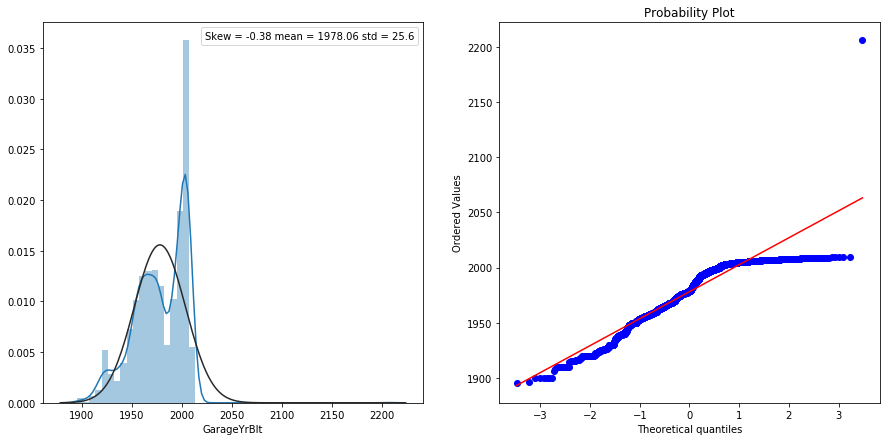

In [77]:
# not sure if I should fill the rest of NaNs with 0 or the yearbuilt house value, lets check distribution
dist_and_prob(data.GarageYrBlt.dropna())

In [78]:
# theres this very weird outlier showing a garage built in the future, lets fix this
data[data.GarageYrBlt > 2018][garage_columns + ["GarageYrBlt" , 'YearBuilt']]

,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars,GarageYrBlt,YearBuilt
Id,,,,,,,
2593,Attchd,RFn,TA,TA,2.0,2207.0,2006


In [79]:
# it seems its a typo, should be 2007
data.loc[2593, 'GarageYrBlt'] = 2007

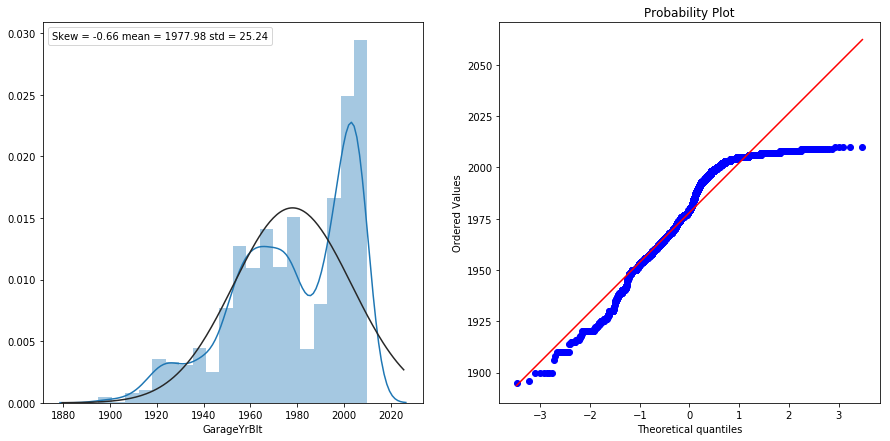

In [80]:
dist_and_prob(data.GarageYrBlt.dropna())

In [81]:
# since 0 will ruin the distribution I'll just fill in the house yearbuilt value for the rest
indexes = data[data.GarageYrBlt.isnull()].index
house_year = data[data.GarageYrBlt.isnull()]['YearBuilt']
data.loc[indexes, 'GarageYrBlt'] = house_year
data.loc[indexes, ['GarageYrBlt', 'YearBuilt']]

,GarageYrBlt,YearBuilt
Id,,
40,1955.0,1955
49,1920.0,1920
79,1968.0,1968
89,1915.0,1915
90,1994.0,1994
100,1959.0,1959
109,1919.0,1919
126,1935.0,1935
128,1930.0,1930


In [82]:
# LotFrontage
lot_columns = list(data.columns[data.columns.str.contains('Lot')])
data[data.LotFrontage.isnull()][lot_columns]

,LotFrontage,LotArea,LotShape,LotConfig
Id,,,,
8,NaN,10382,IR1,Corner
13,NaN,12968,IR2,Inside
15,NaN,10920,IR1,Corner
17,NaN,11241,IR1,CulDSac
25,NaN,8246,IR1,Inside
32,NaN,8544,IR1,CulDSac
43,NaN,9180,IR1,CulDSac
44,NaN,9200,IR1,CulDSac
51,NaN,13869,IR2,Corner


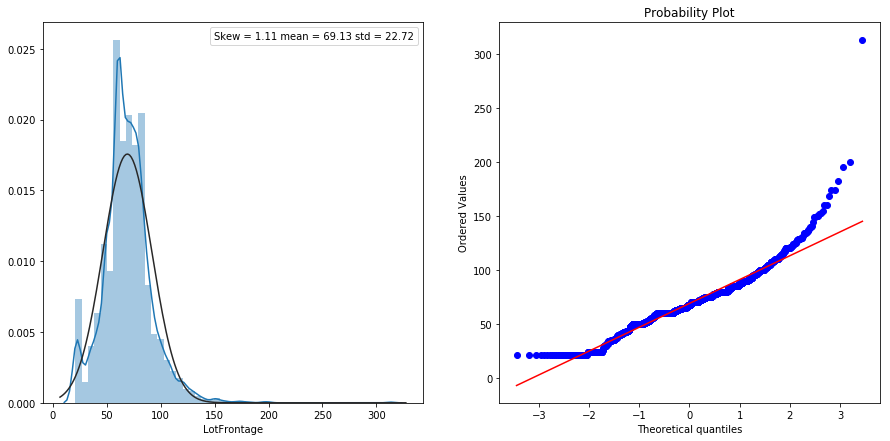

In [83]:
dist_and_prob(data.LotFrontage.dropna())

In [84]:
# since its impossible for a lot to have 0 frontage lets see by neighborhood
data.groupby('Neighborhood').LotFrontage.median()

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    88.5
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [85]:
# fill with neighborhood median
data['LotFrontage'] = data.groupby('Neighborhood').LotFrontage.transform(lambda x: x.fillna(x.median()))

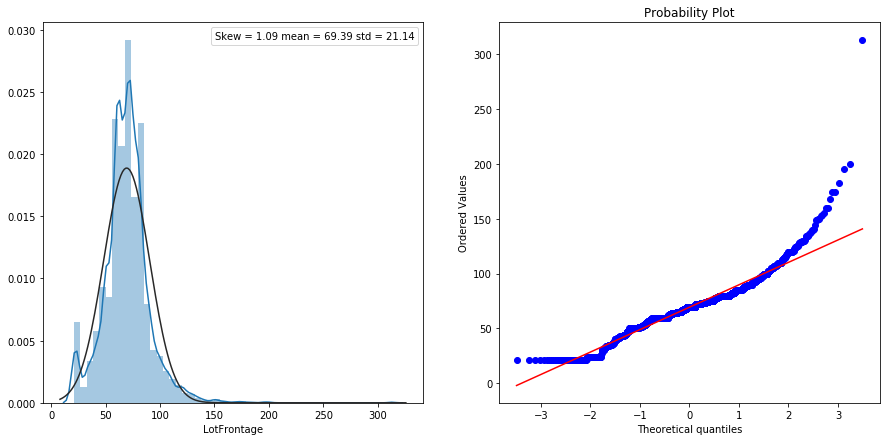

In [86]:
dist_and_prob(data.LotFrontage)

In [87]:
# lets check if the outlier makes sense
data[data.LotFrontage > 220][lot_columns + garage_columns + ['YearBuilt', 'Neighborhood']]

,LotFrontage,LotArea,LotShape,LotConfig,GarageType,GarageFinish,GarageQual,GarageCond,GarageCars,YearBuilt,Neighborhood
Id,,,,,,,,,,,
935,313.0,27650,IR2,Inside,Attchd,RFn,TA,TA,2.0,1960,NAmes


In [88]:
data[(data.Neighborhood == 'NAmes') & (data.LotArea > 17000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
67,20,RL,73.0,19900,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,NaN,NaN,NaN,0,7,2010,WD,Normal,180000.0
172,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,Corner,Gtl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000.0
198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,Corner,Gtl,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000.0
261,80,RL,120.0,19296,Pave,NaN,Reg,Lvl,Corner,Gtl,...,0,NaN,GdWo,NaN,0,5,2009,WD,Normal,176000.0
348,20,RL,73.0,17600,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,157500.0
659,50,RL,78.0,17503,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,97500.0
667,60,RL,73.0,18450,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,NaN,NaN,NaN,0,8,2007,WD,Abnorml,129000.0
935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,Inside,Mod,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000.0
1516,50,RL,120.0,17360,Pave,NaN,Reg,Lvl,Corner,Gtl,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


In [89]:
# Cannot tell from the data so will leave it as is

In [90]:
# FirePlaceQu
data[data.FireplaceQu.isnull()]['Fireplaces'].value_counts()

0    1420
Name: Fireplaces, dtype: int64

In [91]:
# fill with none
data.FireplaceQu.fillna('None', inplace=True)
data.FireplaceQu.isnull().sum()

0

In [92]:
# Fence
data.Fence.isnull().sum()

2345

In [93]:
# per data descrip fill with none
data.Fence.fillna('None', inplace=True)
data.Fence.value_counts()

None     2345
MnPrv     328
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64

In [94]:
# Alley
data.Alley.isnull().sum()

2717

In [95]:
# per data descrip fill with none
data.Alley.fillna('None', inplace=True)
data.Alley.value_counts()

None    2717
Grvl     120
Pave      78
Name: Alley, dtype: int64

In [96]:
# miscfeature
data.MiscFeature.isnull().sum()

2810

In [97]:
# per data descrip fill with none
data.MiscFeature.fillna('None', inplace=True)
data.MiscFeature.value_counts()

None    2810
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64

In [98]:
# PoolQC
data.PoolQC.isnull().sum()

2907

In [99]:
# per data descrip fill with none
data.PoolQC.fillna('None', inplace=True)
data.PoolQC.value_counts()

None    2907
Ex         3
Gd         3
Fa         2
Name: PoolQC, dtype: int64

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2915 entries, 1 to 2919
Data columns (total 79 columns):
MSSubClass       2915 non-null int64
MSZoning         2915 non-null object
LotFrontage      2915 non-null float64
LotArea          2915 non-null int64
Street           2915 non-null object
Alley            2915 non-null object
LotShape         2915 non-null object
LandContour      2915 non-null object
LotConfig        2915 non-null object
LandSlope        2915 non-null object
Neighborhood     2915 non-null object
Condition1       2915 non-null object
Condition2       2915 non-null object
BldgType         2915 non-null object
HouseStyle       2915 non-null object
OverallQual      2915 non-null int64
OverallCond      2915 non-null int64
YearBuilt        2915 non-null int64
YearRemodAdd     2915 non-null int64
RoofStyle        2915 non-null object
RoofMatl         2915 non-null object
Exterior1st      2915 non-null object
Exterior2nd      2915 non-null object
MasVnrType       2915 no

## Filling missing data Done!

In [101]:
# change mssubclass to str
data.MSSubClass = data.MSSubClass.astype(str)

In [102]:
def scatter_box(x):
    plt.figure(figsize=(10,8))
    if str(x.dtype) != 'object':
        sns.regplot(x, data.SalePrice)
    else:
        sns.boxplot(x, data.SalePrice)
        plt.show()
        print(x.value_counts())

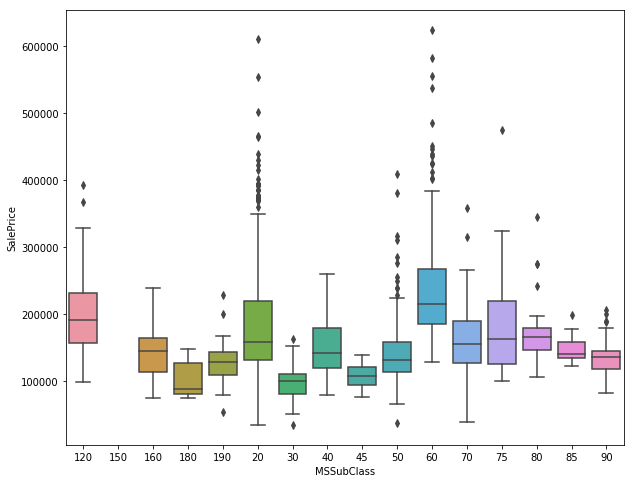

20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64


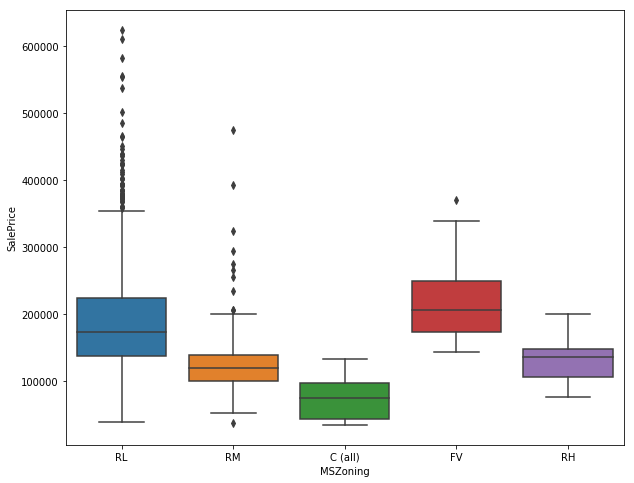

RL         2262
RM          463
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64


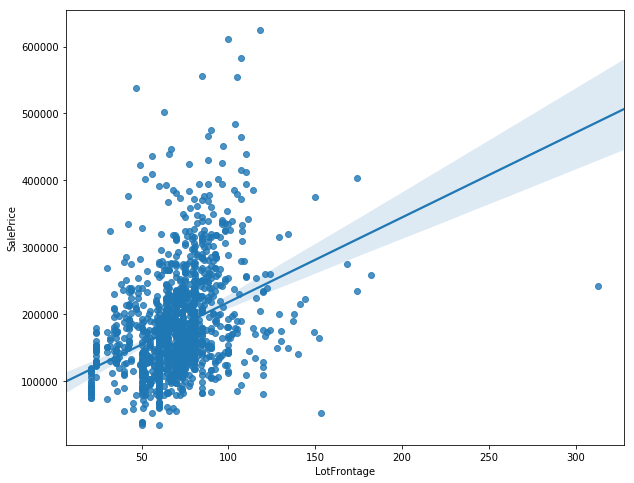

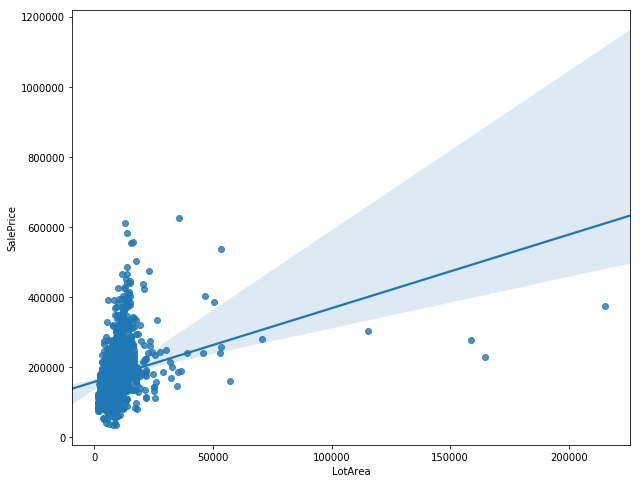

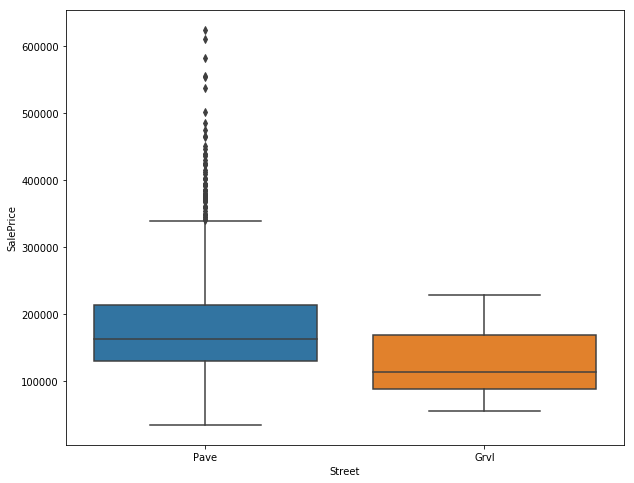

Pave    2903
Grvl      12
Name: Street, dtype: int64


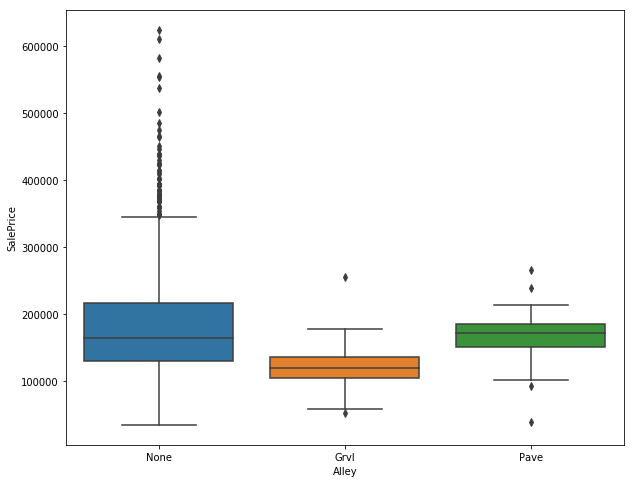

None    2717
Grvl     120
Pave      78
Name: Alley, dtype: int64


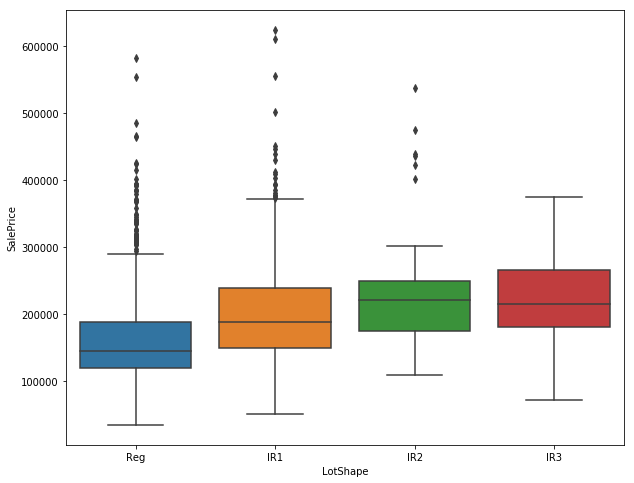

Reg    1859
IR1     965
IR2      76
IR3      15
Name: LotShape, dtype: int64


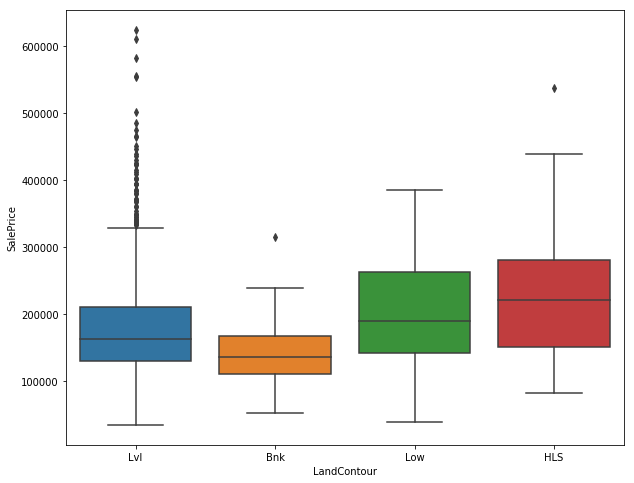

Lvl    2620
HLS     120
Bnk     115
Low      60
Name: LandContour, dtype: int64


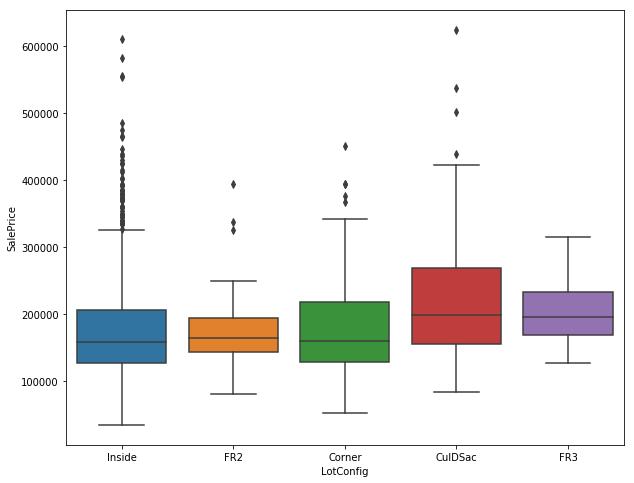

Inside     2132
Corner      508
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64


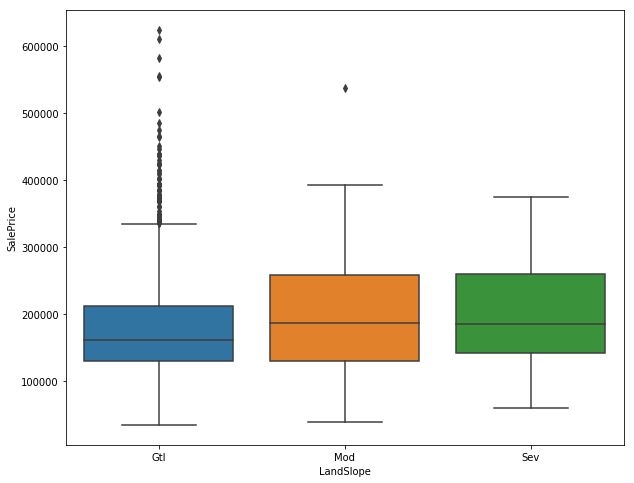

Gtl    2774
Mod     125
Sev      16
Name: LandSlope, dtype: int64


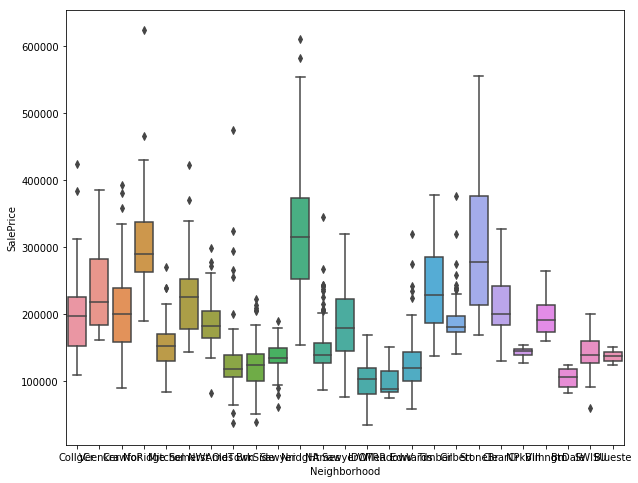

NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64


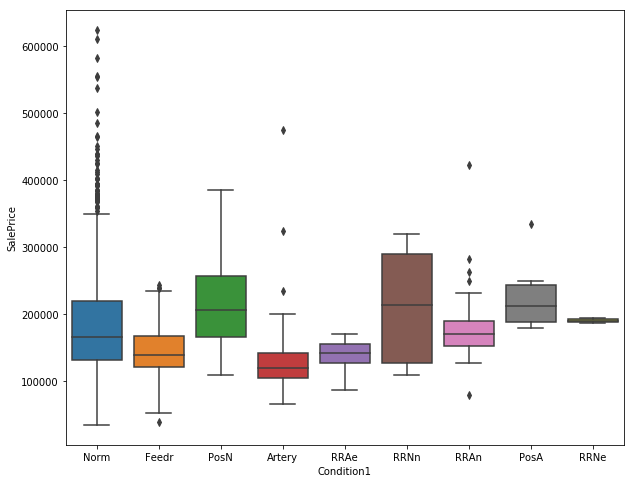

Norm      2509
Feedr      163
Artery      92
RRAn        50
PosN        38
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64


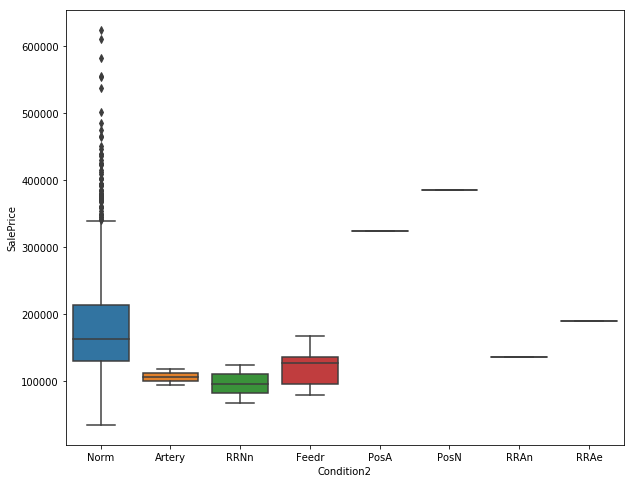

Norm      2886
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64


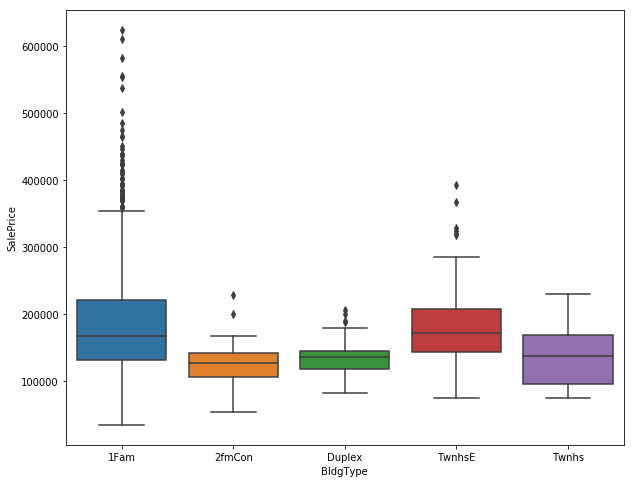

1Fam      2421
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64


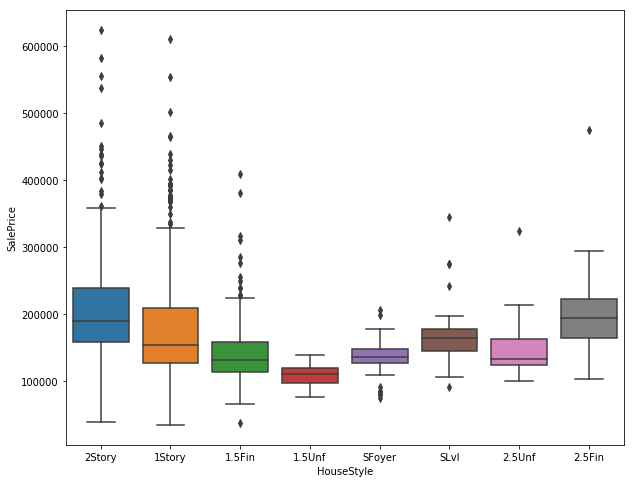

1Story    1471
2Story     868
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64


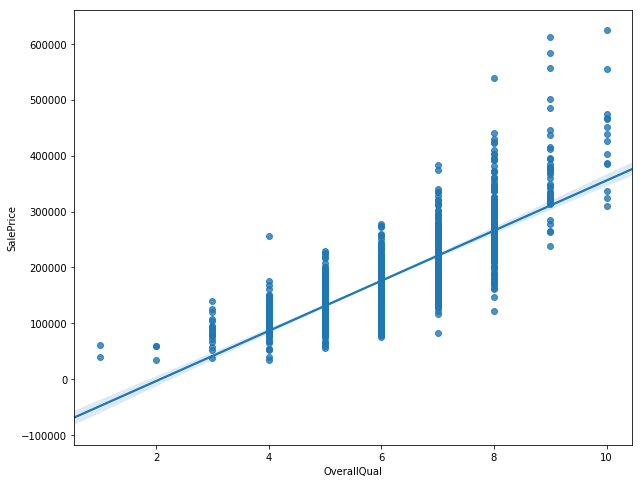

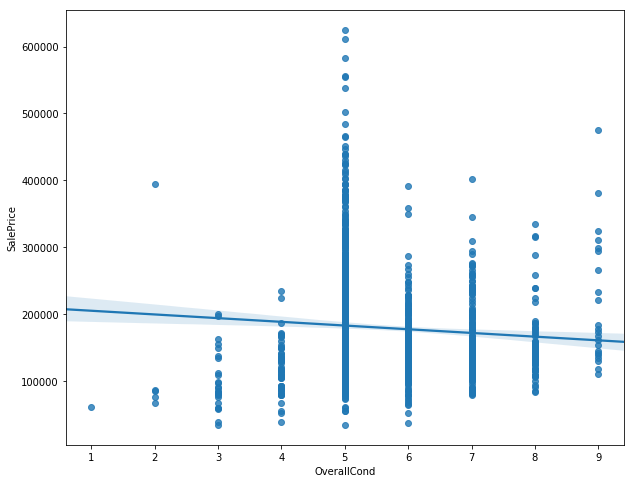

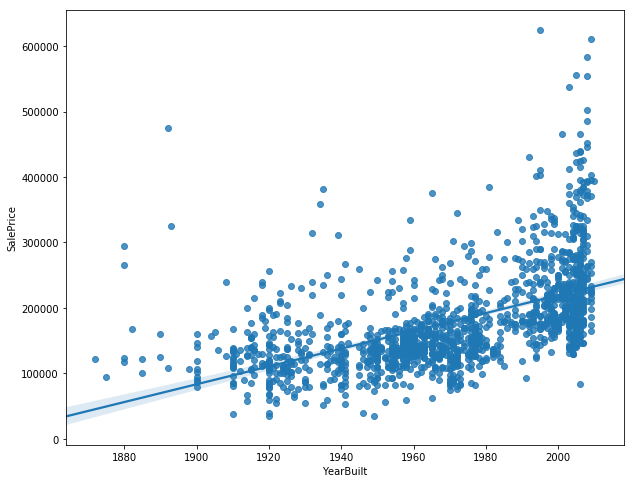

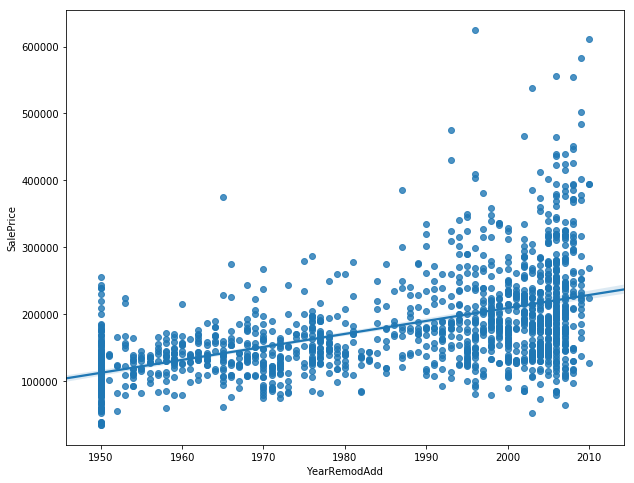

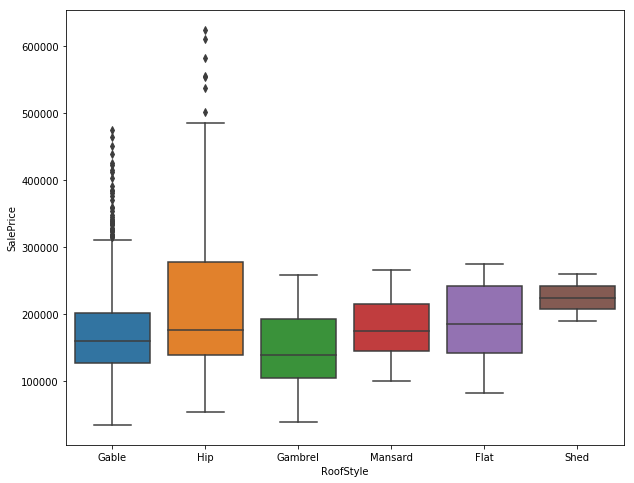

Gable      2309
Hip         548
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64


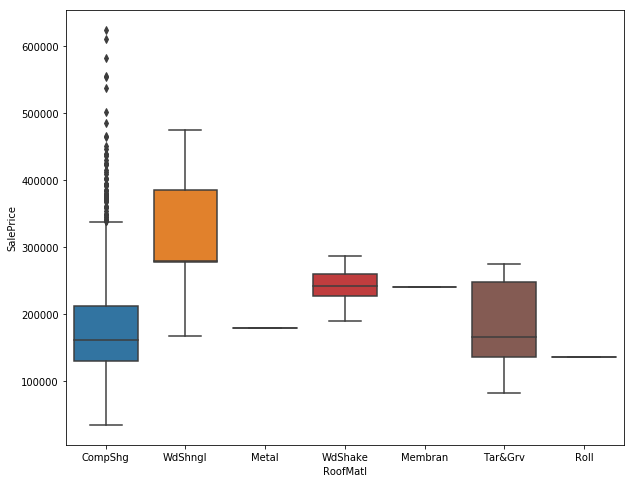

CompShg    2874
Tar&Grv      23
WdShake       9
WdShngl       6
Metal         1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64


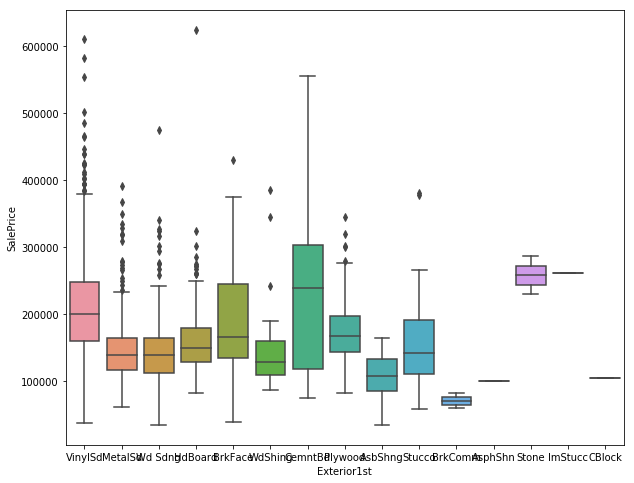

VinylSd    1026
MetalSd     450
HdBoard     441
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
Stone         2
AsphShn       2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64


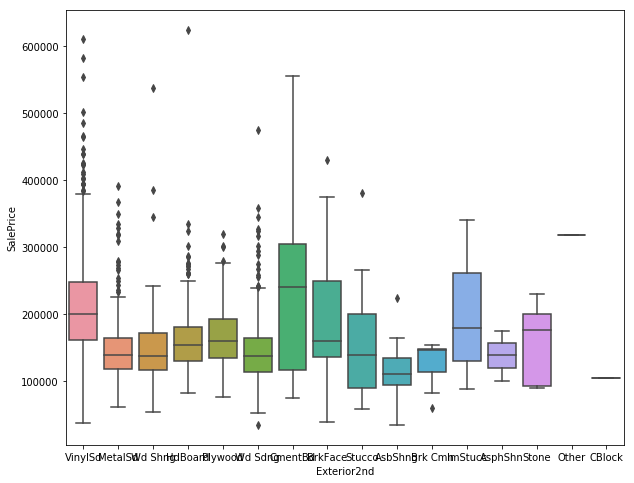

VinylSd    1015
MetalSd     447
HdBoard     405
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      14
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64


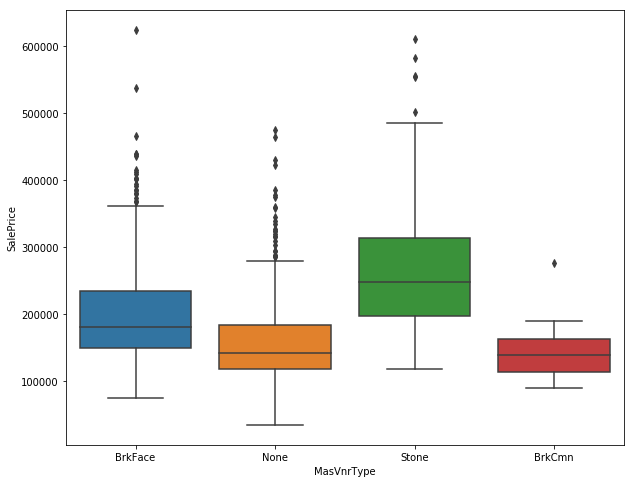

None       1765
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64


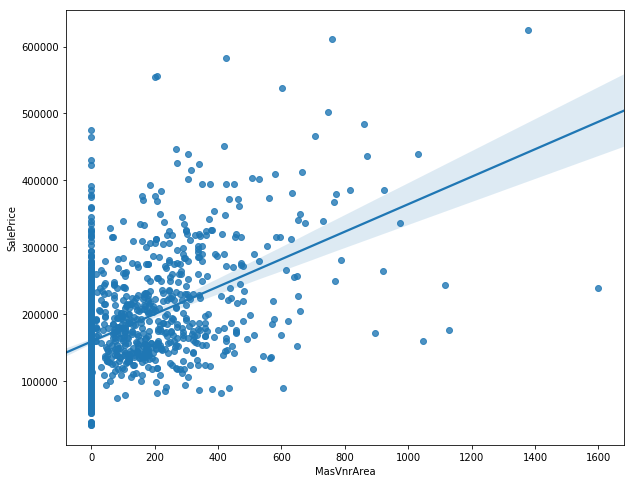

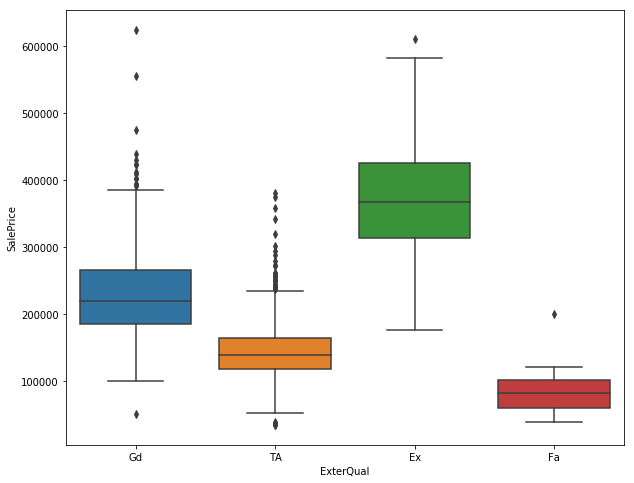

TA    1798
Gd     978
Ex     104
Fa      35
Name: ExterQual, dtype: int64


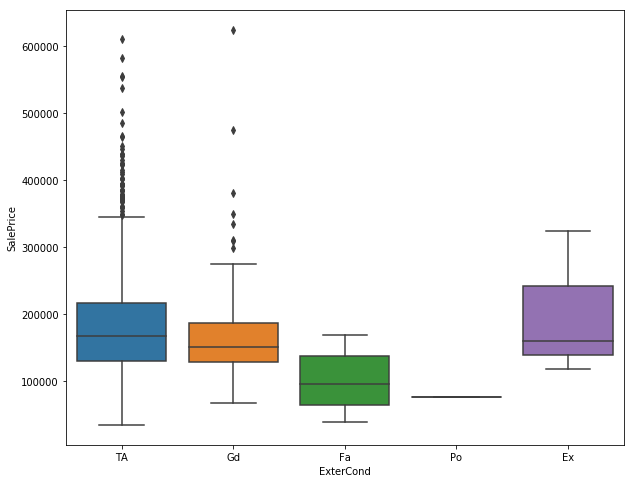

TA    2534
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64


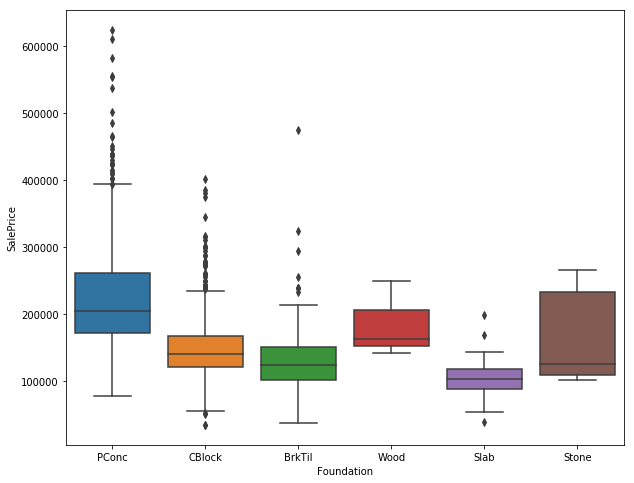

PConc     1304
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: Foundation, dtype: int64


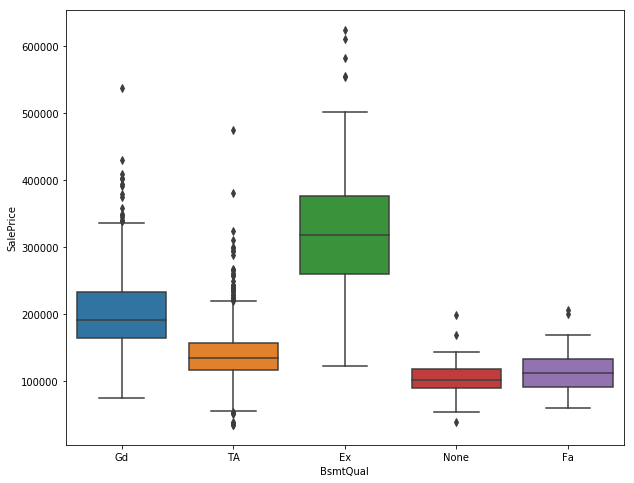

TA      1285
Gd      1209
Ex       254
Fa        88
None      79
Name: BsmtQual, dtype: int64


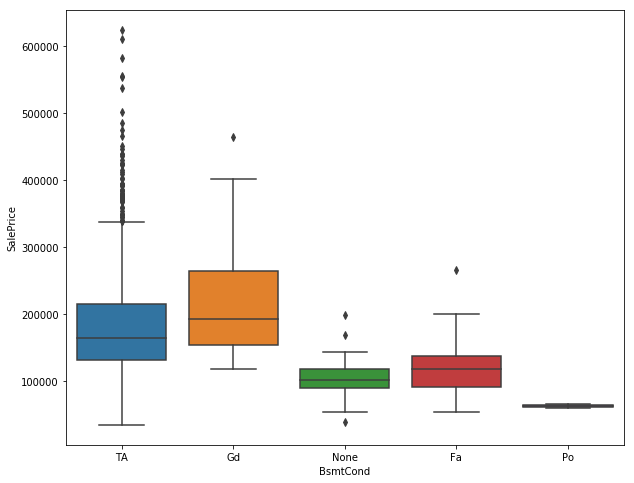

TA      2605
Gd       122
Fa       104
None      79
Po         5
Name: BsmtCond, dtype: int64


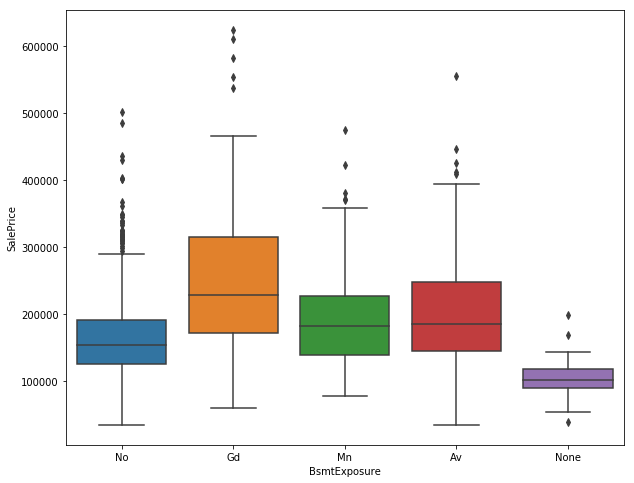

No      1907
Av       417
Gd       273
Mn       239
None      79
Name: BsmtExposure, dtype: int64


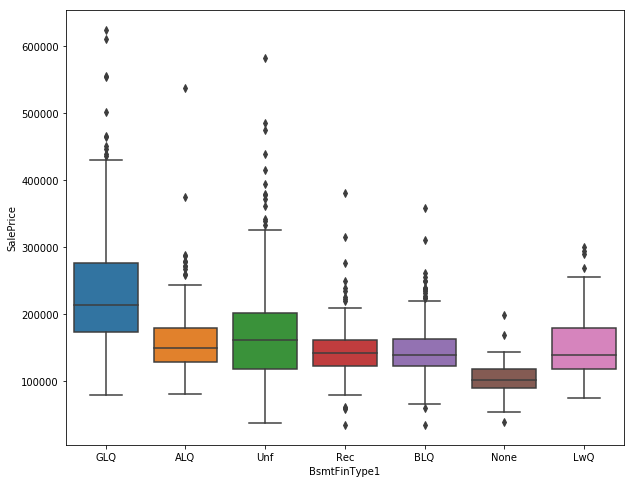

Unf     851
GLQ     845
ALQ     429
Rec     288
BLQ     269
LwQ     154
None     79
Name: BsmtFinType1, dtype: int64


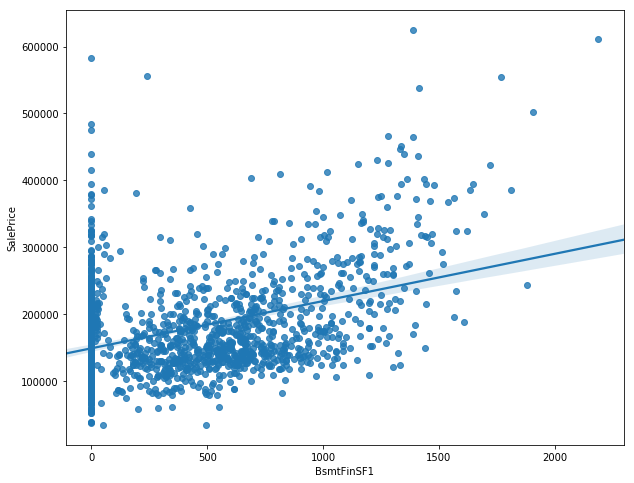

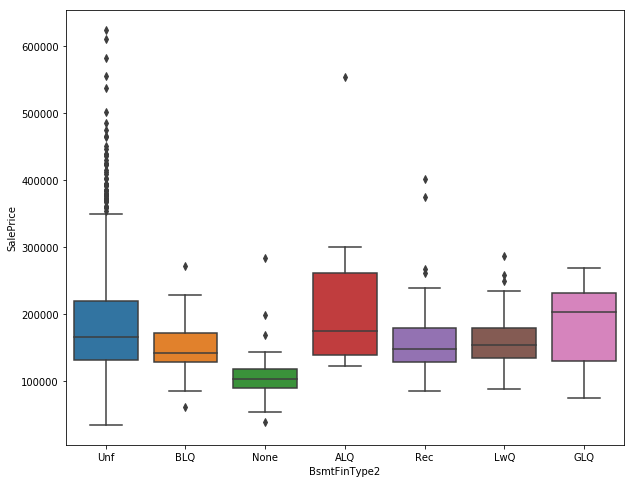

Unf     2489
Rec      105
LwQ       87
None      80
BLQ       68
ALQ       52
GLQ       34
Name: BsmtFinType2, dtype: int64


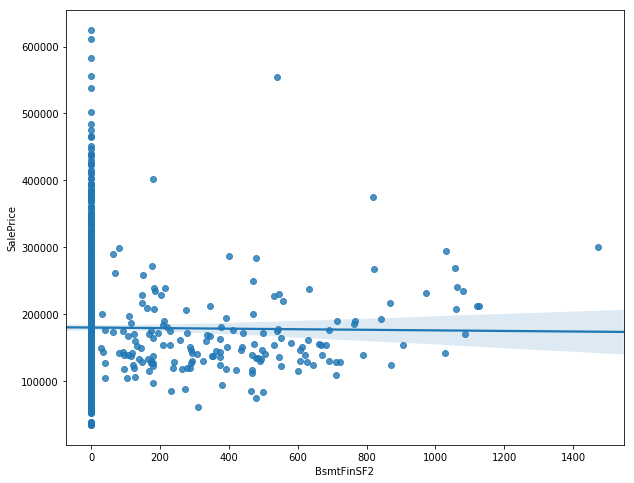

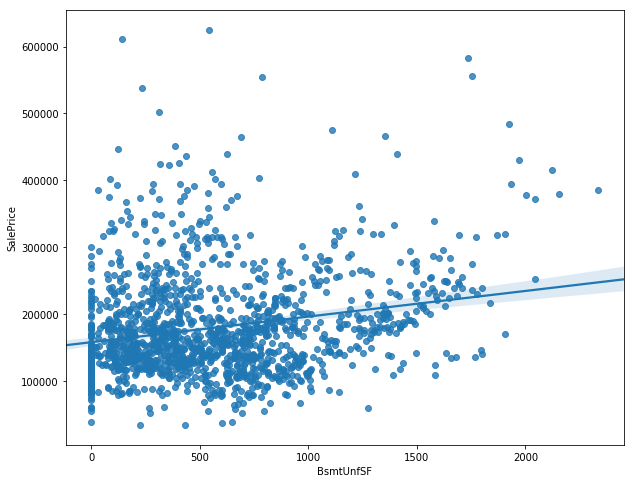

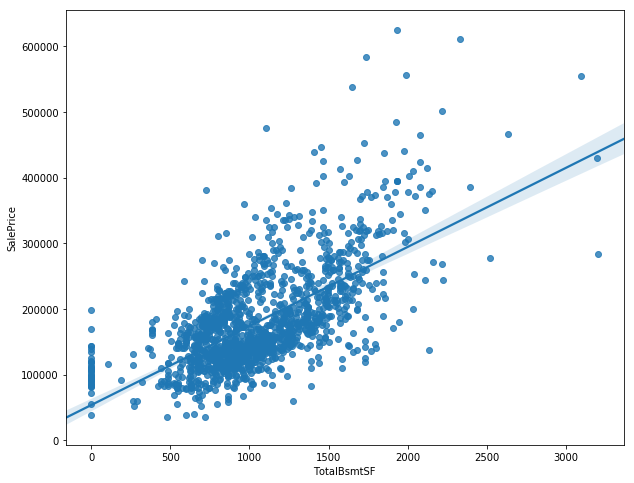

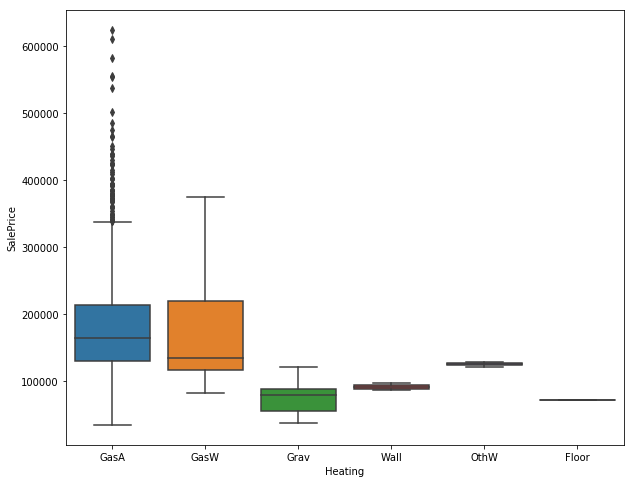

GasA     2870
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64


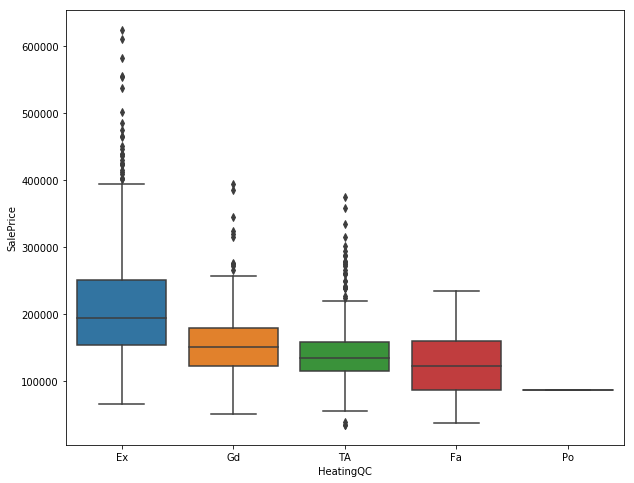

Ex    1489
TA     857
Gd     474
Fa      92
Po       3
Name: HeatingQC, dtype: int64


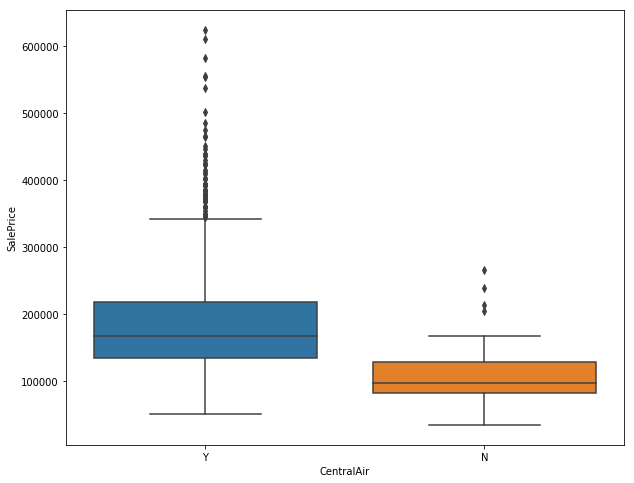

Y    2719
N     196
Name: CentralAir, dtype: int64


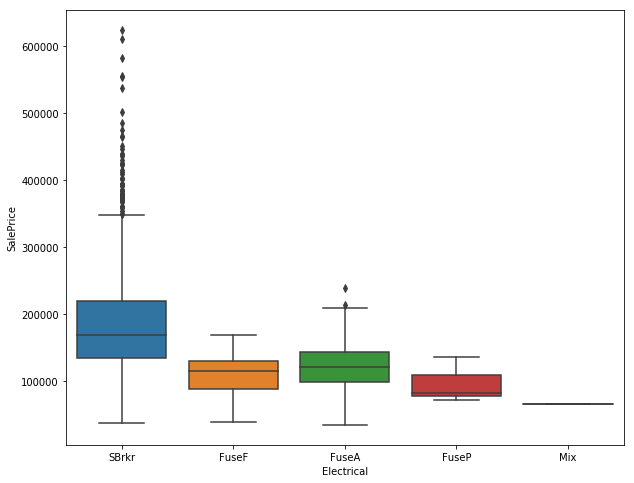

SBrkr    2668
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


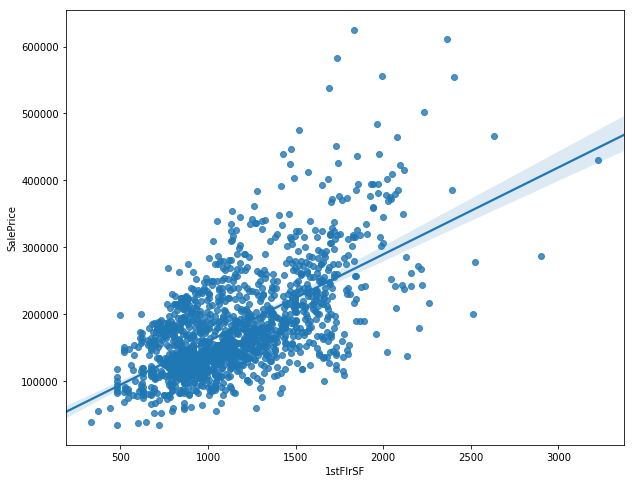

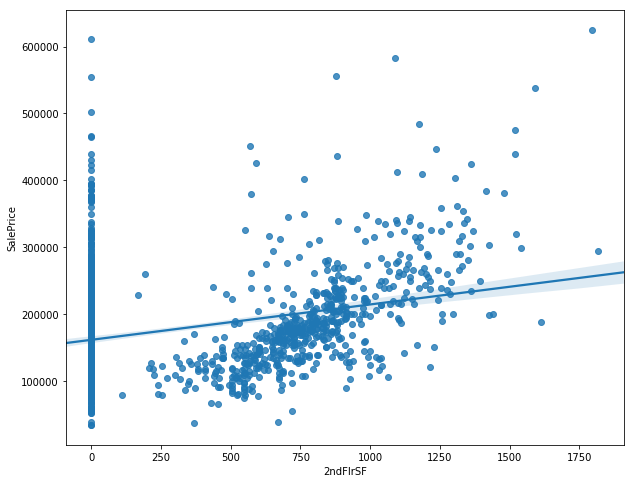

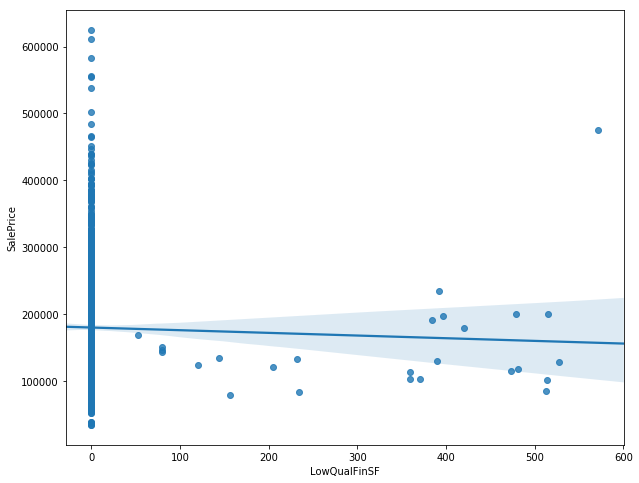

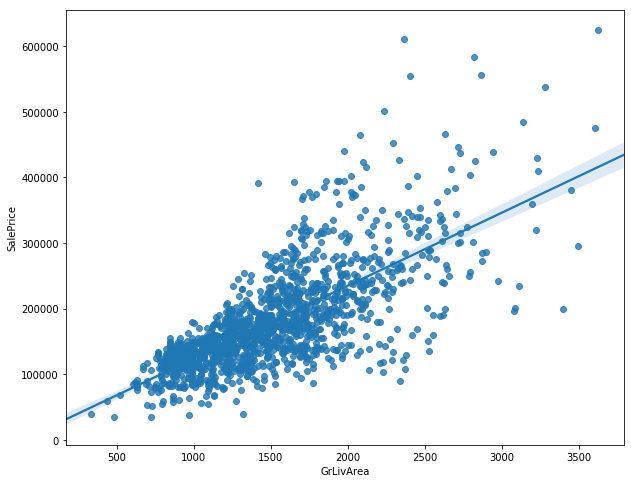

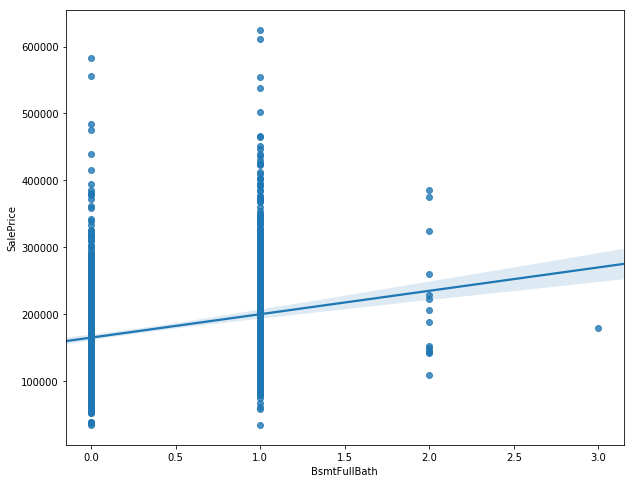

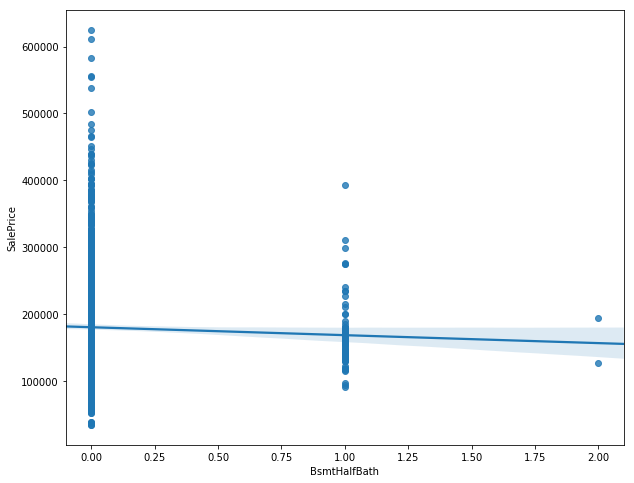

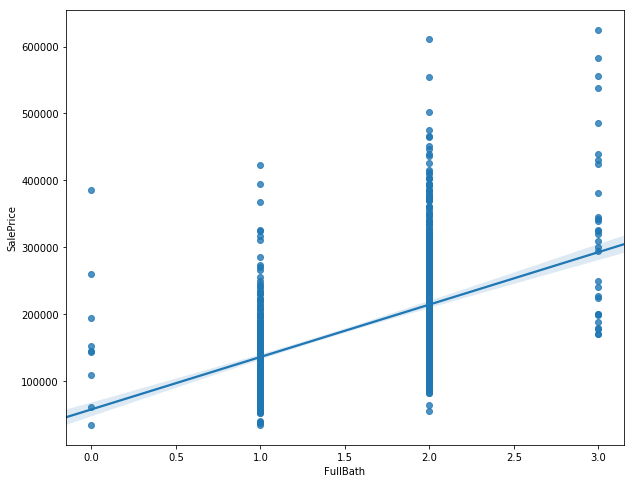

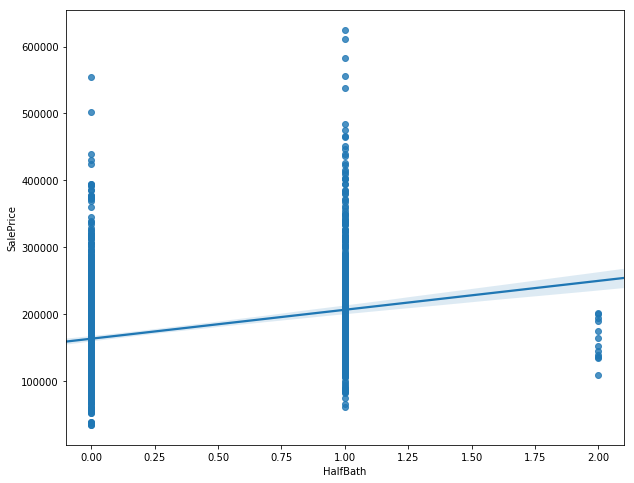

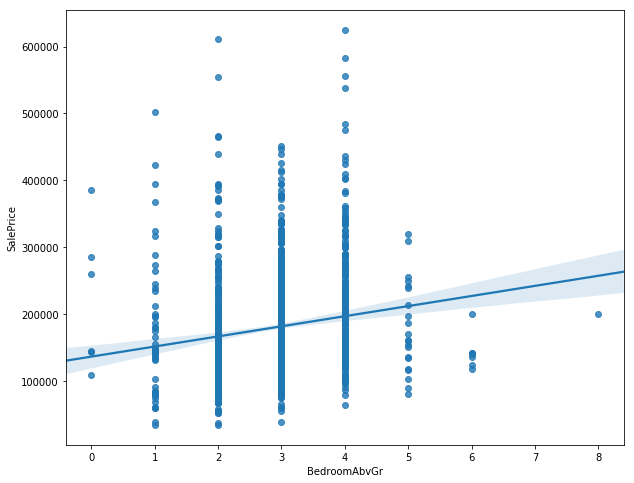

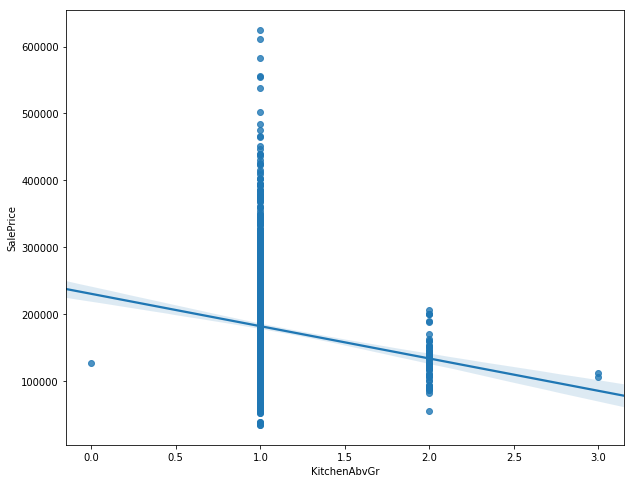

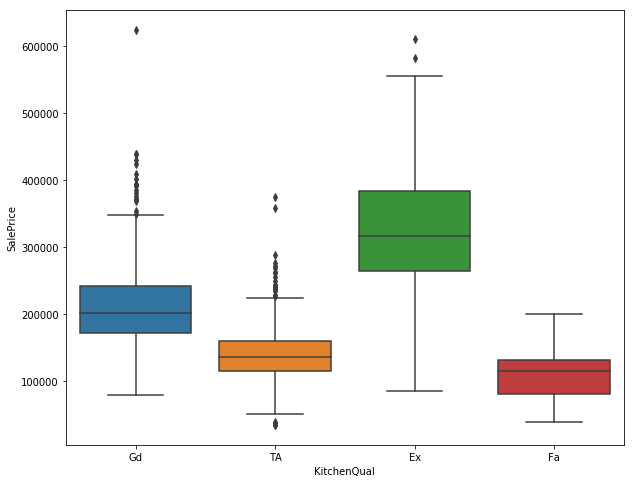

TA    1493
Gd    1151
Ex     201
Fa      70
Name: KitchenQual, dtype: int64


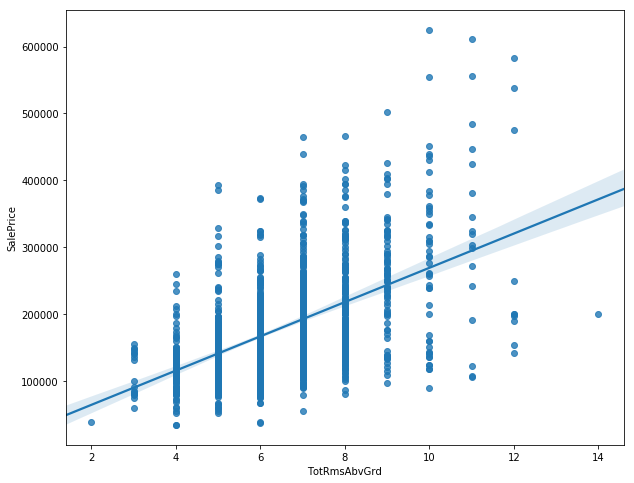

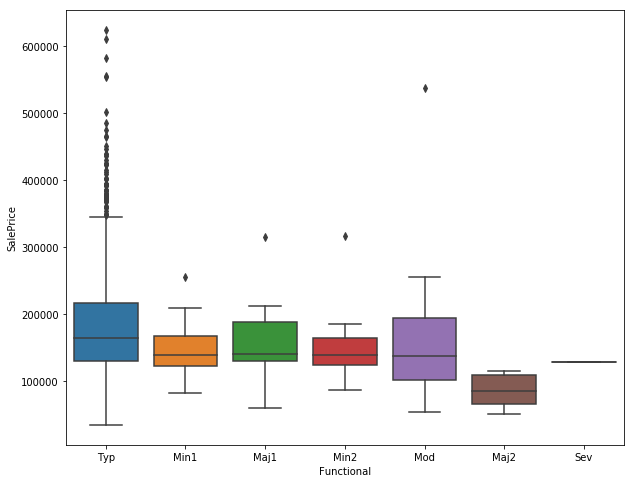

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64


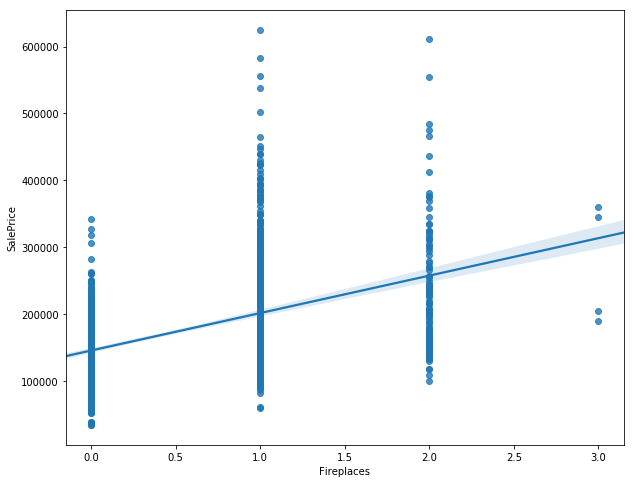

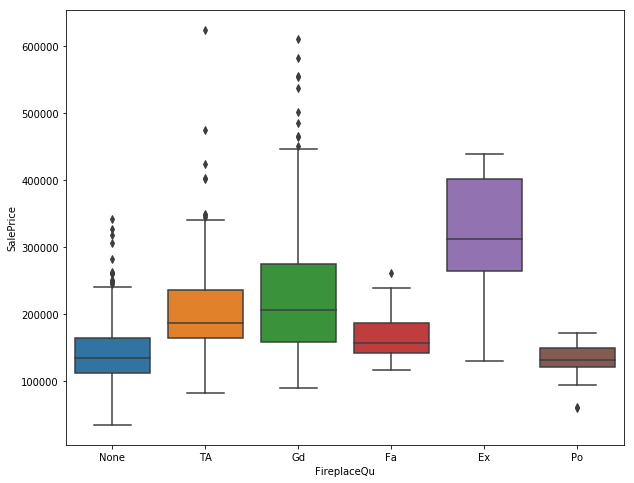

None    1420
Gd       742
TA       591
Fa        74
Po        46
Ex        42
Name: FireplaceQu, dtype: int64


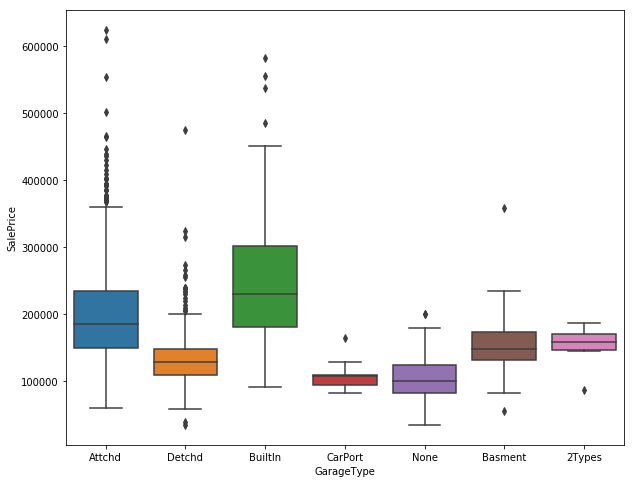

Attchd     1720
Detchd      778
BuiltIn     185
None        158
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64


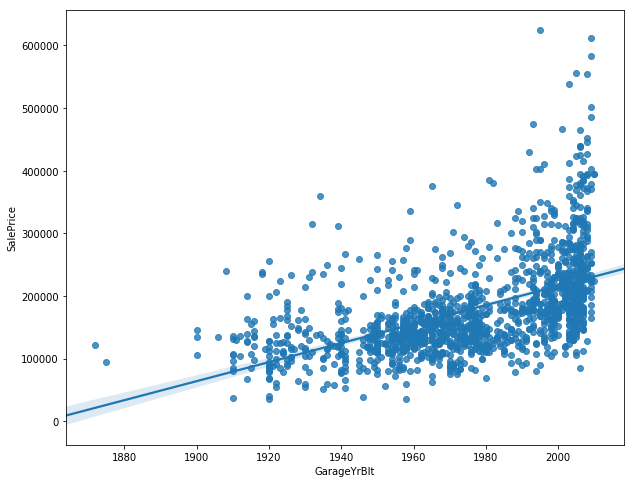

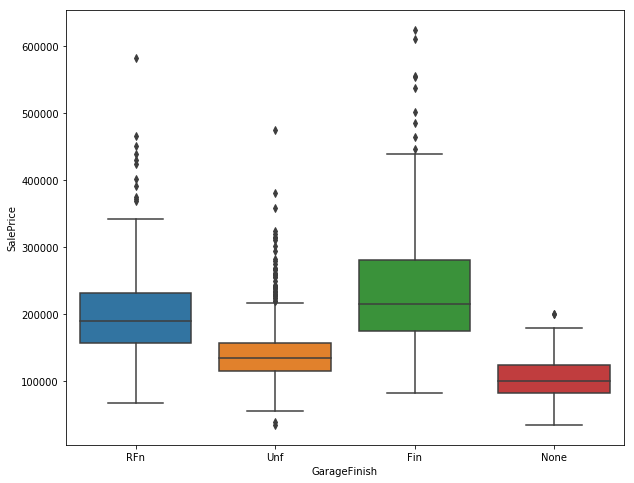

Unf     1231
RFn      811
Fin      715
None     158
Name: GarageFinish, dtype: int64


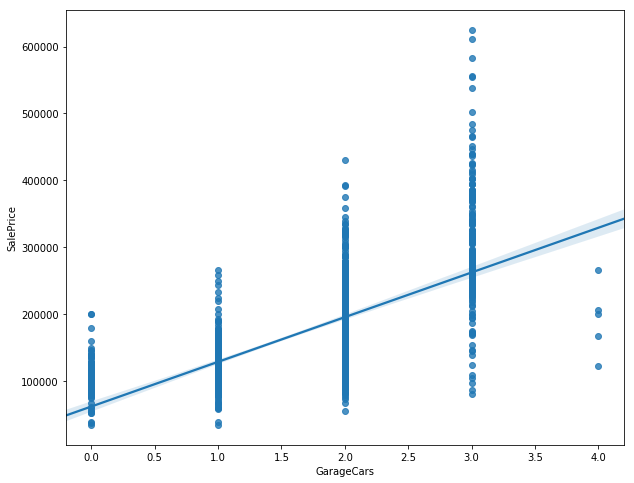

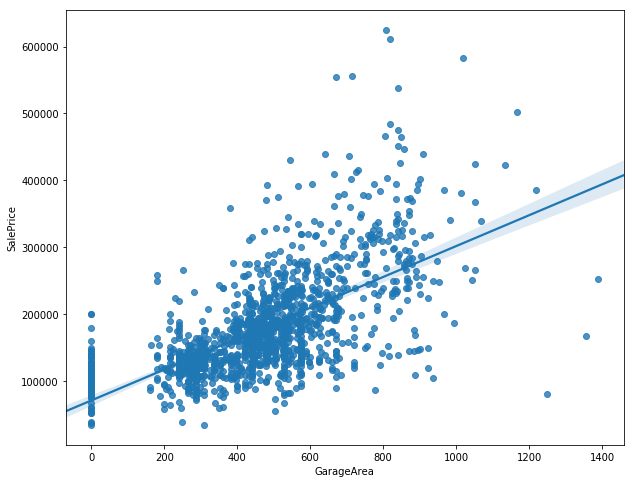

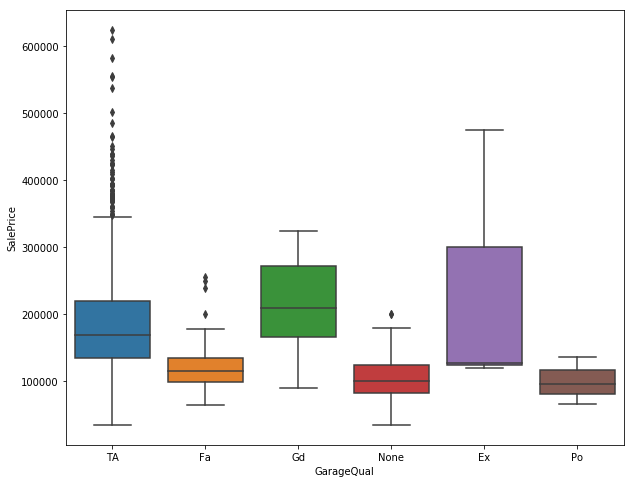

TA      2601
None     158
Fa       124
Gd        24
Po         5
Ex         3
Name: GarageQual, dtype: int64


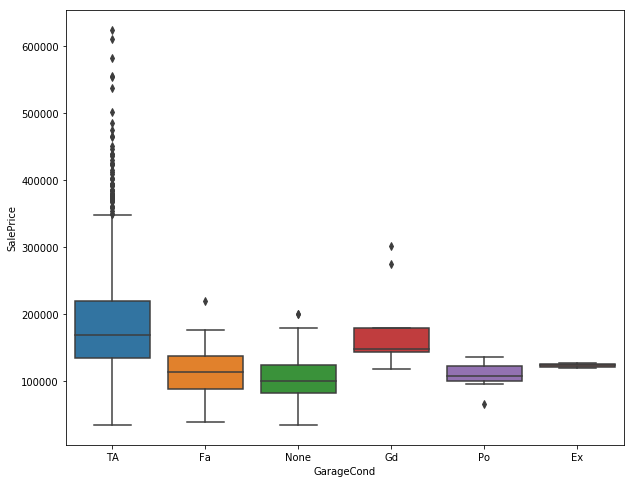

TA      2651
None     158
Fa        74
Gd        15
Po        14
Ex         3
Name: GarageCond, dtype: int64


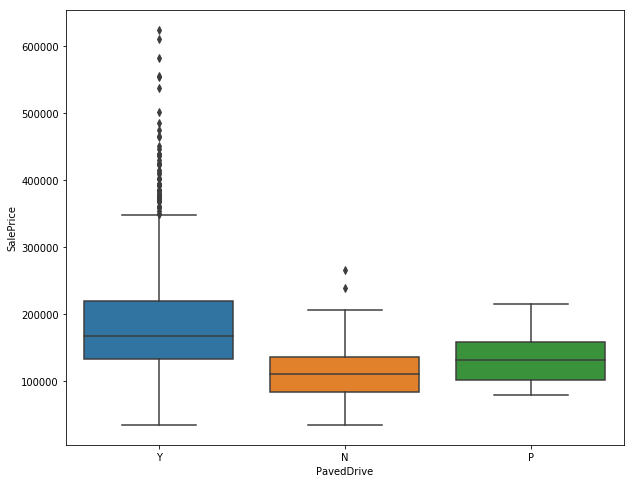

Y    2637
N     216
P      62
Name: PavedDrive, dtype: int64


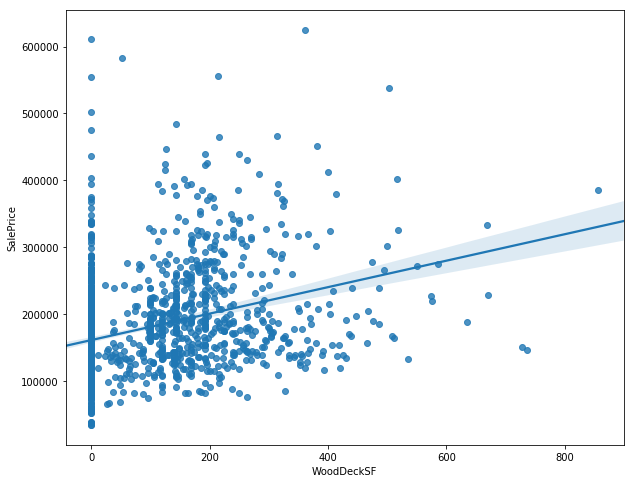

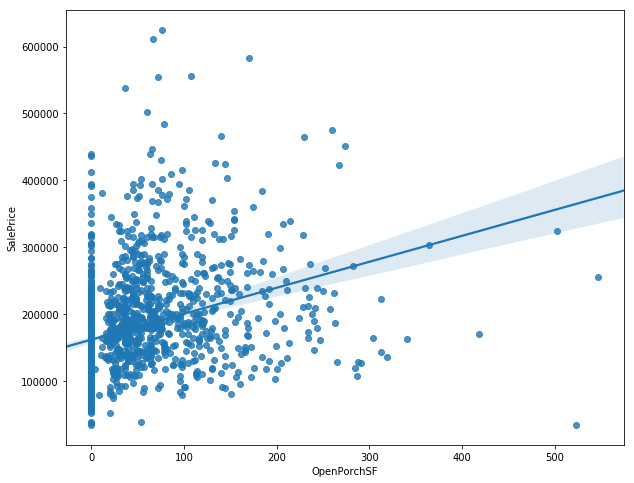

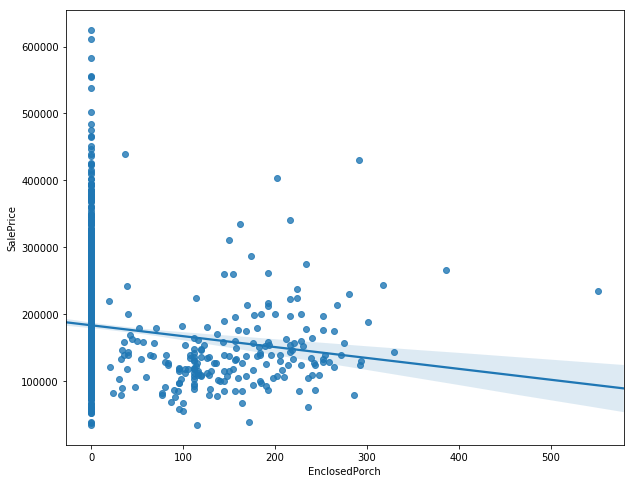

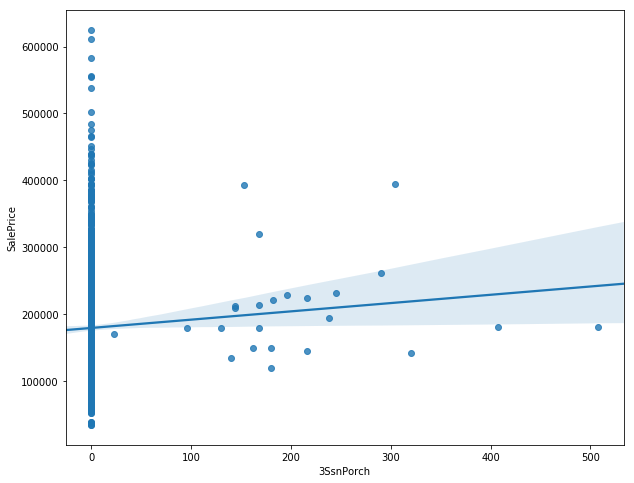

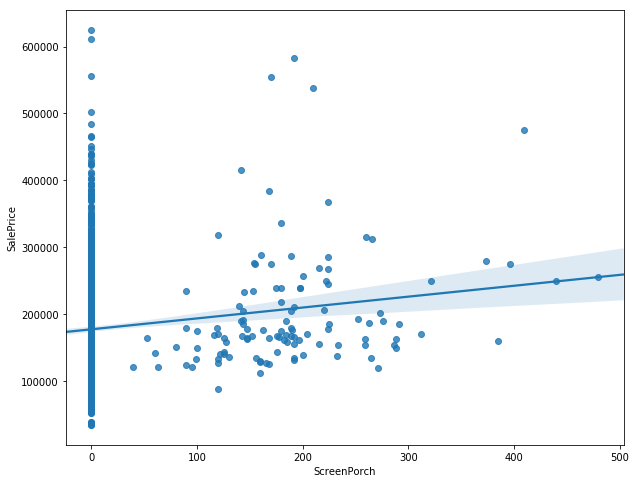

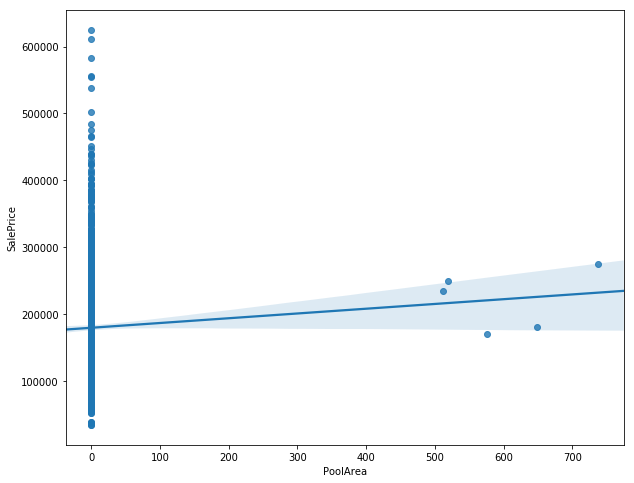

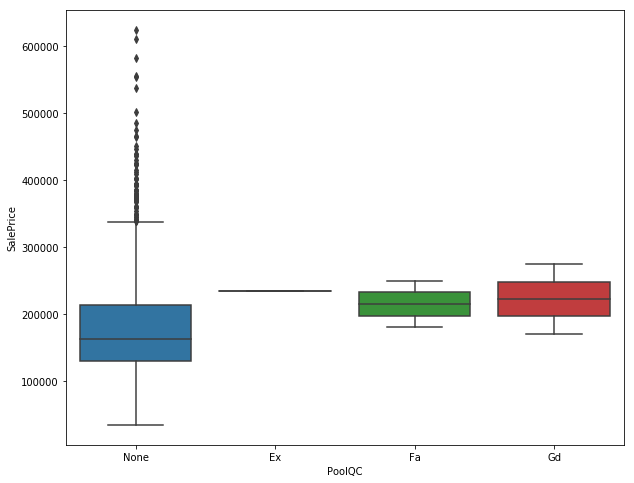

None    2907
Ex         3
Gd         3
Fa         2
Name: PoolQC, dtype: int64


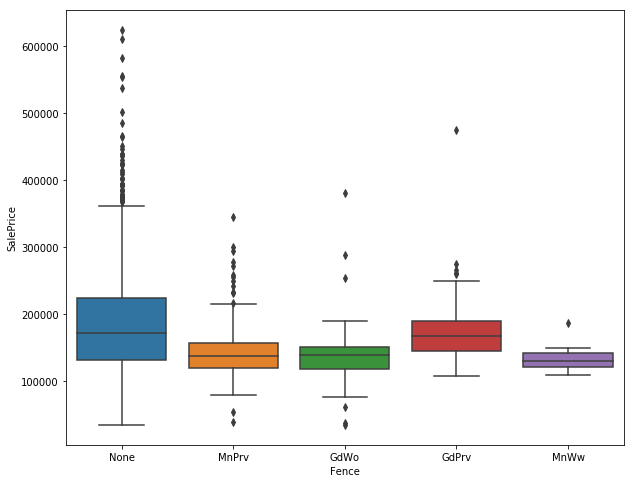

None     2345
MnPrv     328
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64


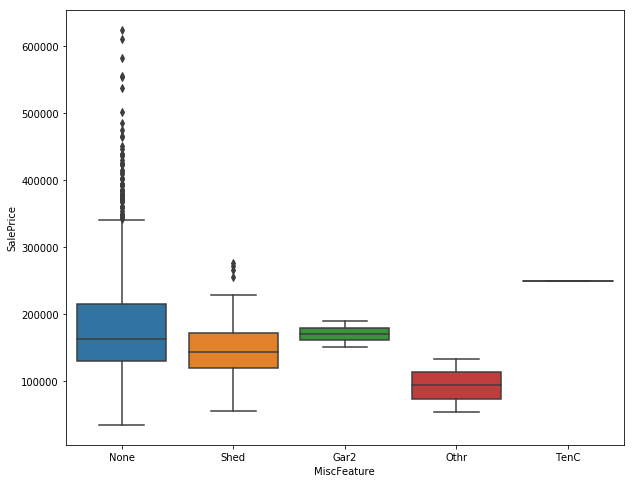

None    2810
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64


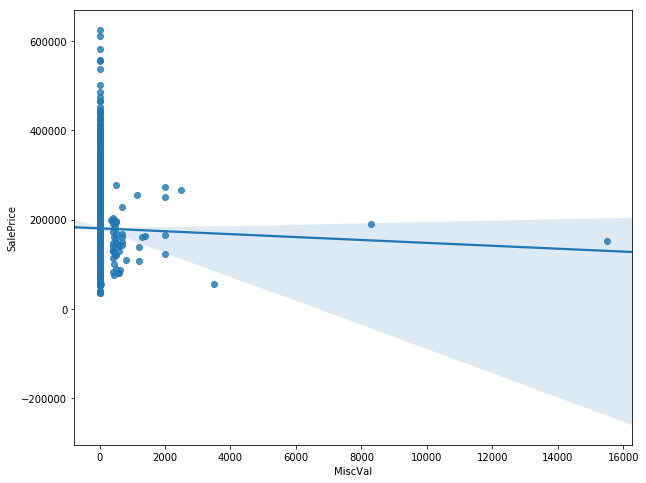

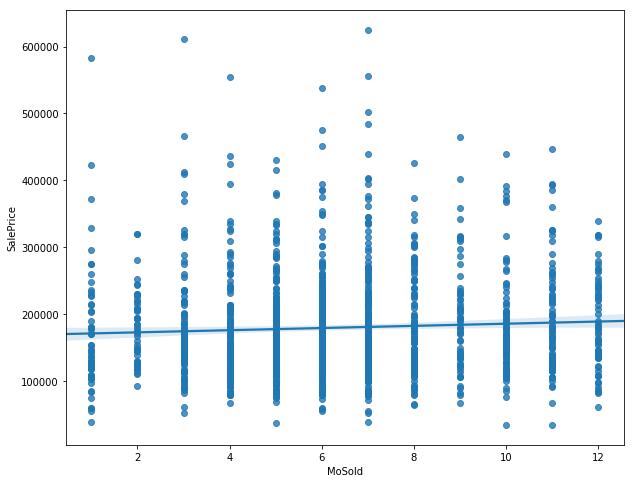

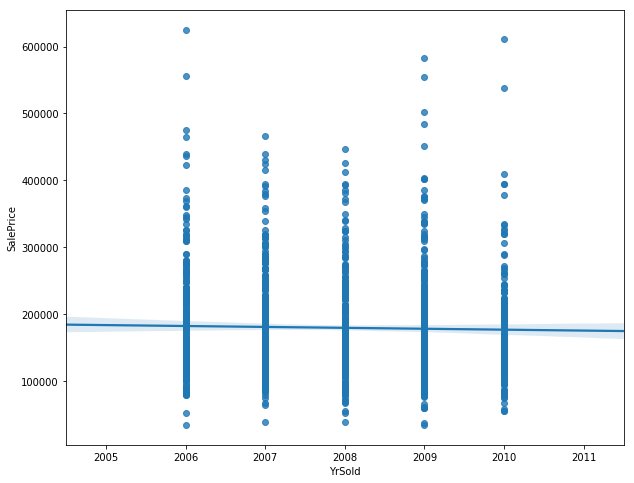

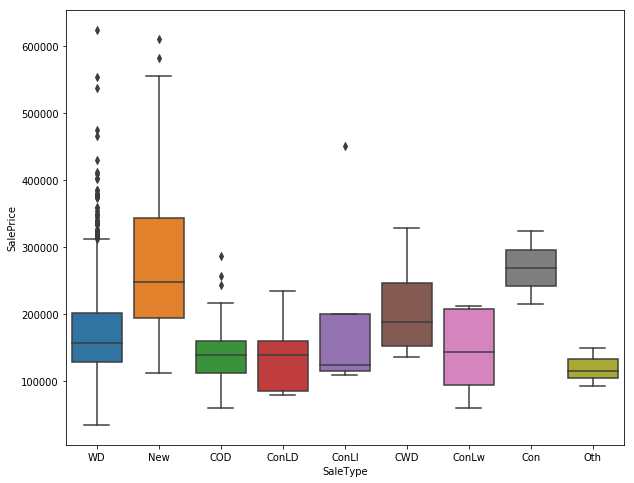

WD       2524
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64


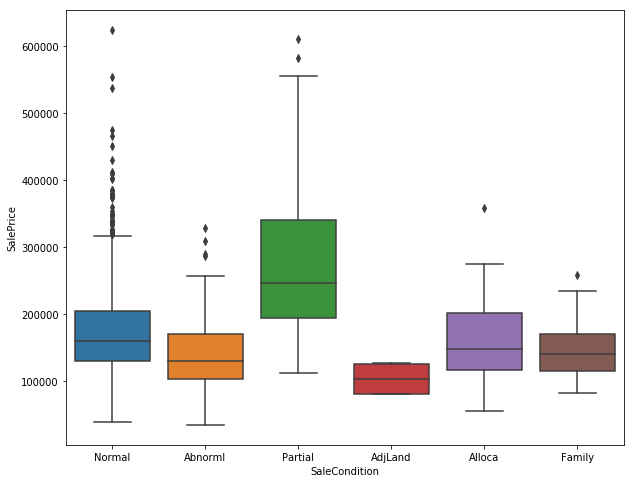

Normal     2401
Partial     243
Abnorml     189
Family       46
Alloca       24
AdjLand      12
Name: SaleCondition, dtype: int64


In [103]:
# Lets go through features and see their scatter/box plot and distribution
for column in data.drop('SalePrice', axis=1).columns:
    scatter_box(data[column])

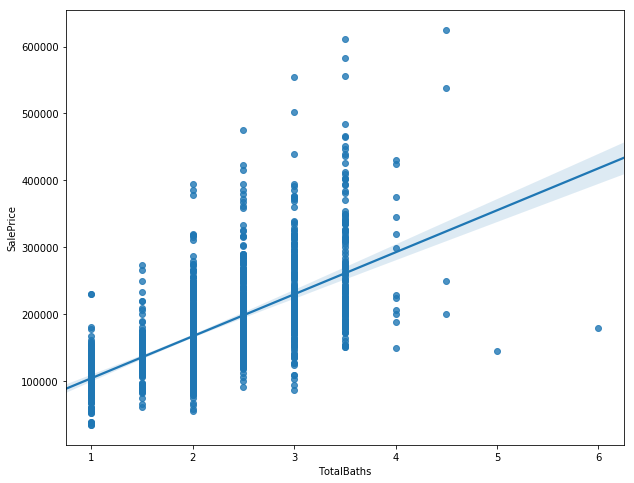

In [104]:
# will create new column totalbaths
data['TotalBaths'] = (data.HalfBath/2) + (data.BsmtHalfBath/2) + (data.FullBath) + (data.BsmtFullBath)
scatter_box(data.TotalBaths)

In [105]:
# change orderly categories of interest into nums
data.ExterQual = data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

In [106]:
data.BsmtQual = data.BsmtQual.map({'None':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

In [107]:
data.BsmtExposure = data.BsmtExposure.map({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})

In [108]:
data.HeatingQC = data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

In [109]:
data.KitchenQual = data.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

In [110]:
# make dummies for features of interest
data['FireplaceQu_isNone'] = data.FireplaceQu.transform(lambda x: 1 if x == 'None' else 0)
data.FireplaceQu_isNone.value_counts()

0    1495
1    1420
Name: FireplaceQu_isNone, dtype: int64

In [111]:
data['PavedDrive_isY'] = data.PavedDrive.transform(lambda x: 1 if x == 'Y' else 0)
data.PavedDrive_isY.value_counts()

1    2637
0     278
Name: PavedDrive_isY, dtype: int64

In [112]:
data['SaleType_isNew'] = data.SaleType.transform(lambda x: 1 if x == 'New' else 0)
data.SaleType_isNew.value_counts()

0    2678
1     237
Name: SaleType_isNew, dtype: int64

In [113]:
data['SaleCondition_isPartial'] = data.SaleCondition.transform(lambda x: 1 if x == 'Partial' else 0)
data.SaleCondition_isPartial.value_counts()

0    2672
1     243
Name: SaleCondition_isPartial, dtype: int64

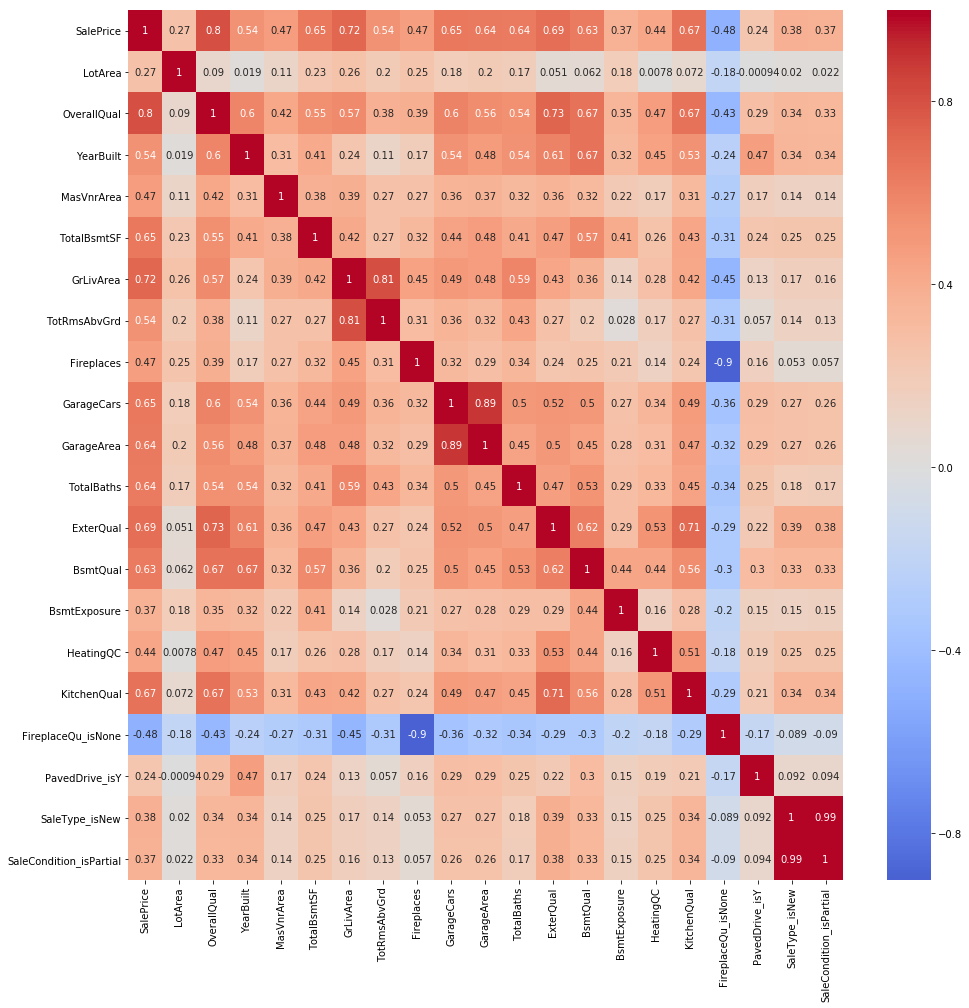

In [114]:
# getting ideas on what features to keep, lets try a heatmap
interest_columns = ['SalePrice', 'LotArea', 'OverallQual', 'YearBuilt', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'TotRmsAbvGrd',
                    'Fireplaces', 'GarageCars', 'GarageArea', 'TotalBaths', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'HeatingQC',
                    'KitchenQual', 'FireplaceQu_isNone', 'PavedDrive_isY', 'SaleType_isNew', 'SaleCondition_isPartial']
plt.figure(figsize=(16,16))
sns.heatmap(data[interest_columns].corr(), center=0, annot=True, cmap='coolwarm');

Will keep Garagearea and remove Garagecars because they fit in for each other and also the same with GrLivArea & totRms and SaleTypeNew & Salecond partial

In [115]:
# dummify features of interest

def dummify_column(data, column):
    return pd.concat((data, pd.get_dummies(data[column.name], prefix=column.name, prefix_sep='_is')), axis=1)
    
data = dummify_column(data, data.MSSubClass)
data = dummify_column(data, data.MSZoning)
data = dummify_column(data, data.LotShape)
data = dummify_column(data, data.Neighborhood)
data = dummify_column(data, data.HouseStyle)
data = dummify_column(data, data.RoofStyle)
data = dummify_column(data, data.MasVnrType)
data = dummify_column(data, data.Foundation)
data = dummify_column(data, data.GarageType)
data = dummify_column(data, data.CentralAir).drop('CentralAir_isN', axis=1)
data = dummify_column(data, data.GarageFinish).drop('GarageFinish_isNone', axis=1)

In [116]:
data.shape

(2915, 169)

In [117]:
# keep only numeric features of interest
columns_to_drop = [data[column].name for column in list(data.columns) if data[column].dtype == 'object'] + ['SalePrice', 'LotArea', 'LotFrontage', 'TotRmsAbvGrd', 'Fireplaces',
                                                                                                            'GarageCars', 'SaleType_isNew', 'OverallCond', 'YearRemodAdd',
                                                                                                            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
                                                                                                            'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                                                                                                           'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt',
                                                                                                            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                                                                                                           'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

In [118]:
# Get X and Y
X = data.drop(columns_to_drop, axis=1)
y = data.SalePrice

X.shape, y.shape

((2915, 100), (2915,))

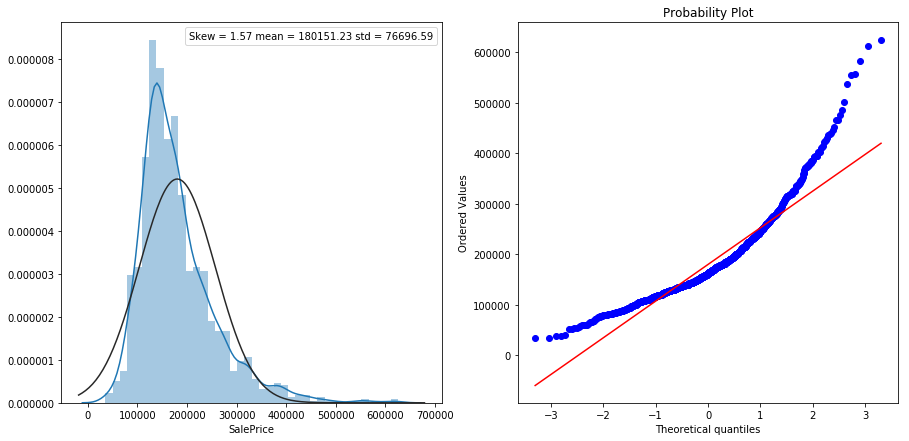

In [119]:
y_train = y[y.notnull()]
dist_and_prob(y_train)

In [120]:
# lets try to get it to a normal distribution using log1p
y_train = np.log1p(y_train)

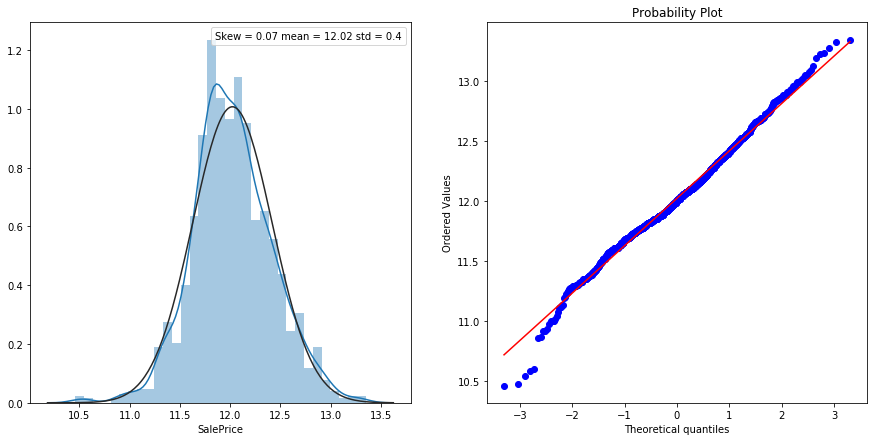

In [121]:
dist_and_prob(y_train)

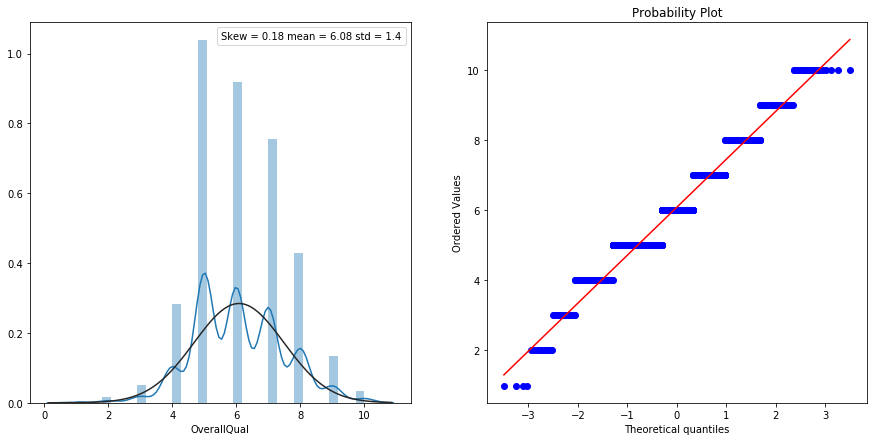

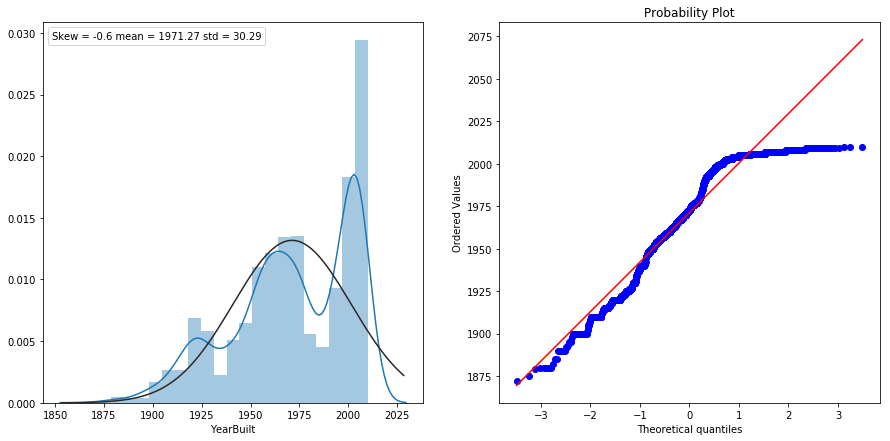

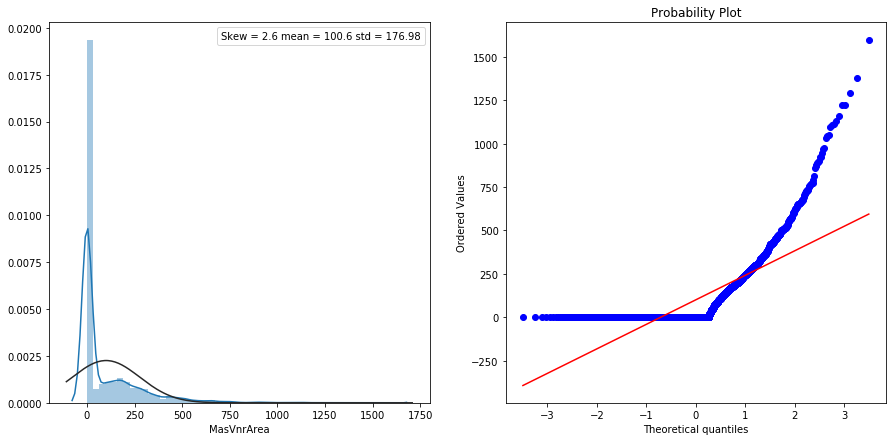

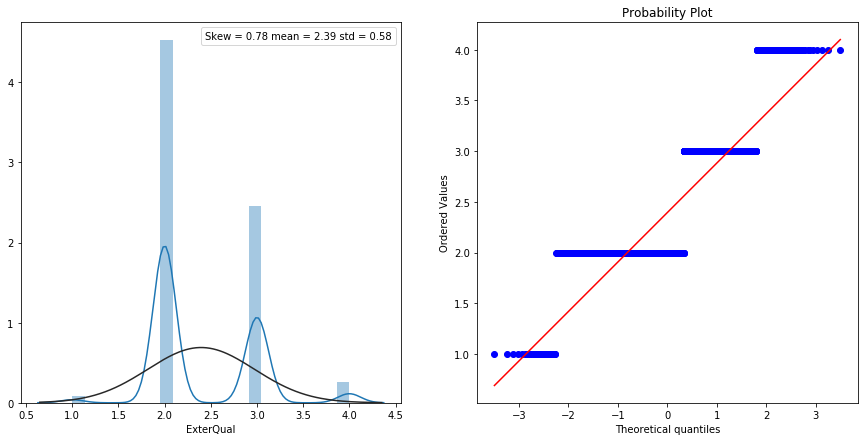

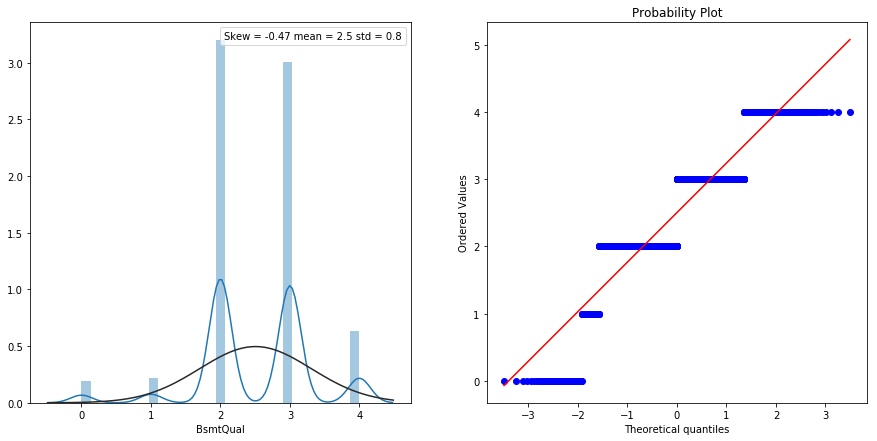

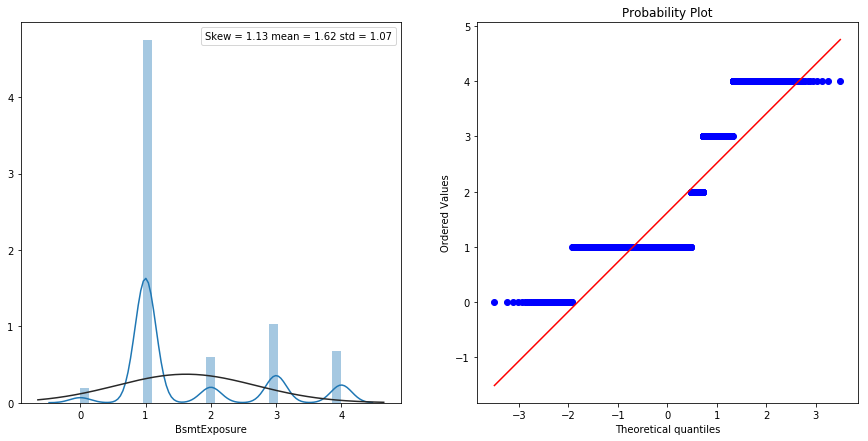

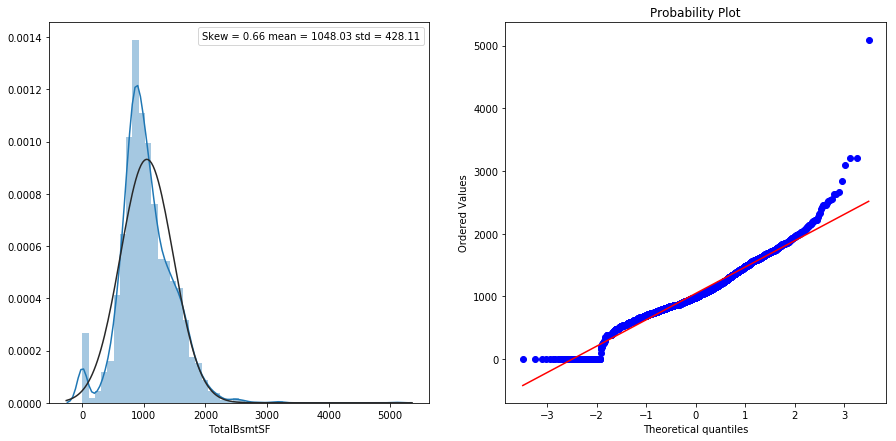

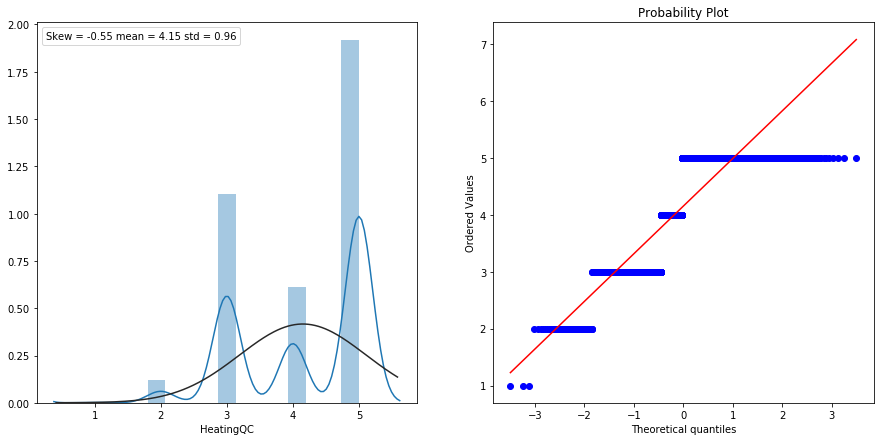

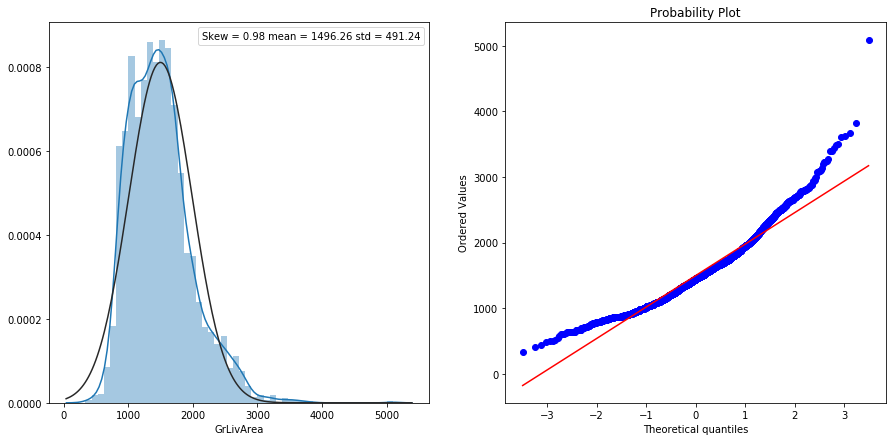

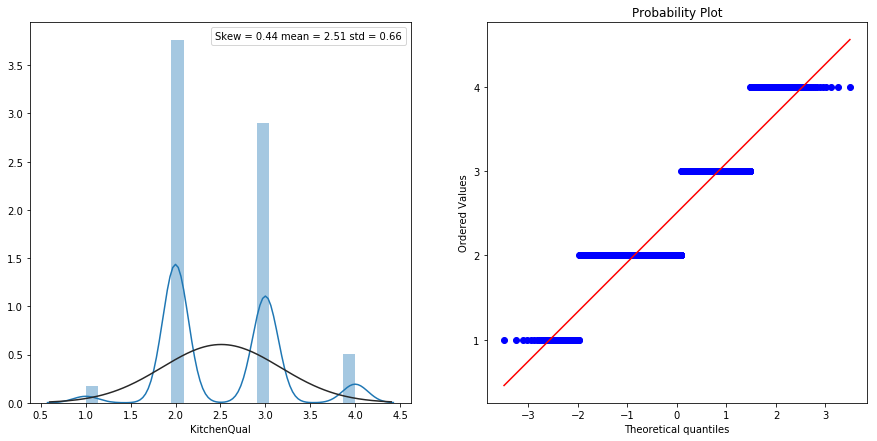

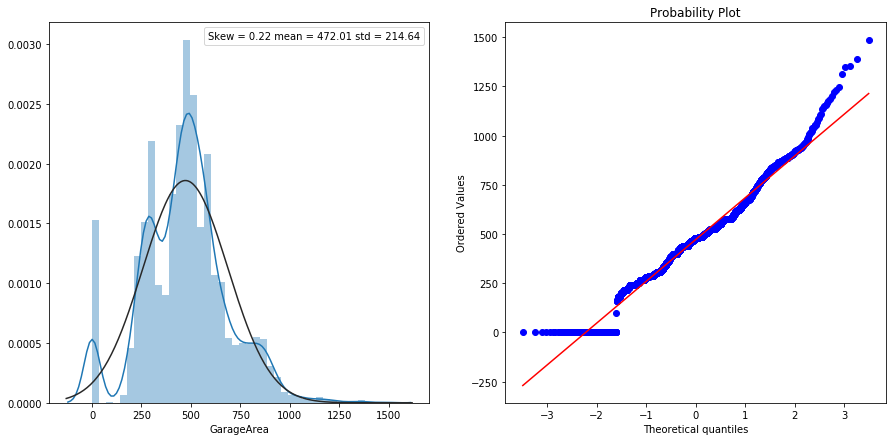

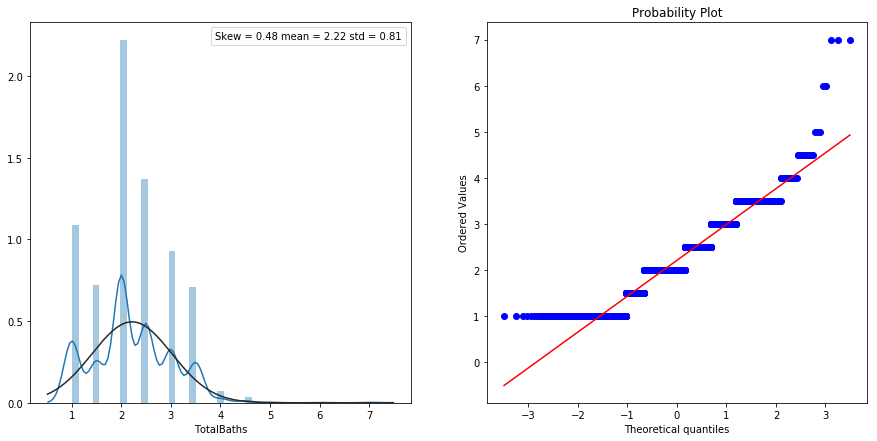

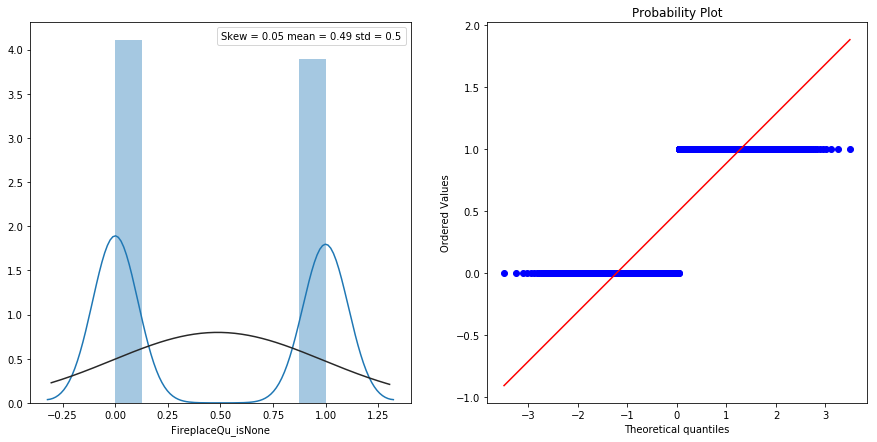

In [122]:
# now lets see distribution of X features
for column in list(X.loc[:,:'FireplaceQu_isNone'].columns):
    dist_and_prob(X[column])

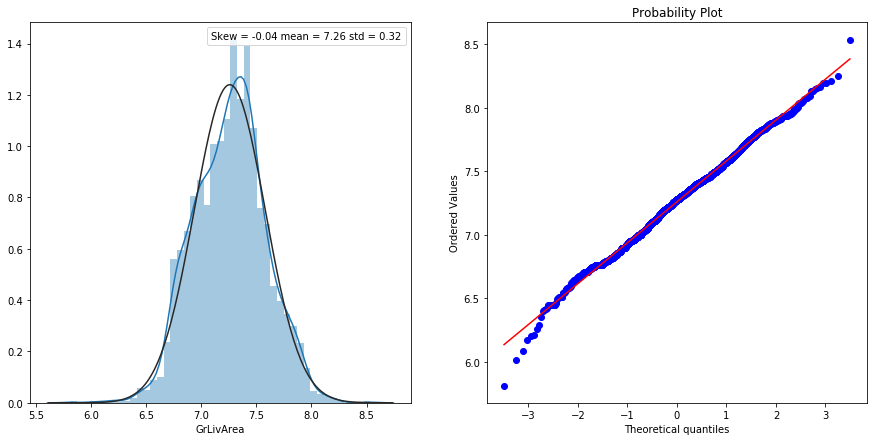

In [123]:
# lets try log1p for GrLivArea
X.GrLivArea = np.log1p(X.GrLivArea)
dist_and_prob(X.GrLivArea)

In [124]:
# split back to train and test
X_train = X[y.notnull()]
X_test = X[y.isnull()]

X_train.shape, X_test.shape, y_train.shape

((1456, 100), (1459, 100), (1456,))

# Time to model!

In [125]:
# sklearn imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

In [126]:
# scale the data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\TQ\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [127]:
# lets use the dummy regressor to get a baseline RMSE
dummy = DummyRegressor()
dummy.fit(X_train_ss, y_train)
dummy.score(X_train_ss, y_train)

0.0

In [128]:
# as expected score is 0 because its the baseline and equal to mean
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(dummy.predict(X_train_ss))))

77899.73612581371

In [129]:
np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(dummy.predict(X_train_ss))))

0.3959412098902504

In [130]:
# lets do a linear regression first
lin_reg = LinearRegression()
lin_reg.fit(X_train_ss, y_train);

In [131]:
# lets use crossval in combo with pipeline to get an R2 score
scaler = StandardScaler()
lr = LinearRegression()
pipeline = Pipeline([('transformer', scaler), ('estimator', lr)])
cv = KFold(n_splits=10, shuffle=True, random_state=42)

lr_scores = cross_val_score(pipeline, X_train, y_train, cv=cv);

C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, i

In [132]:
lr_scores.mean()

0.8906538709198338

In [133]:
# now lets see RMSE
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(lin_reg.predict(X_train_ss))))

21820.664602043333

In [134]:
np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(lin_reg.predict(X_train_ss))))

0.11761582901174682

Not a bad start, lets move on to Ridge and Lasso

In [135]:
# Ridge
ridge_reg = Ridge(alpha=.5)
ridge_reg.fit(X_train_ss, y_train);

In [136]:
scaler = StandardScaler()
rr = Ridge(alpha=.5)
pipeline = Pipeline([('transformer', scaler), ('estimator', rr)])
cv = KFold(n_splits=10, shuffle=True)

rr_scores = cross_val_score(pipeline, X_train, y_train, cv=cv);

C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, i

In [137]:
rr_scores.mean()

0.8928478171298577

In [138]:
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(ridge_reg.predict(X_train_ss))))

21821.865707650137

In [139]:
np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(ridge_reg.predict(X_train_ss))))

0.117615867022749

In [140]:
# Lasso
lasso_reg = Lasso(alpha=.00005)
lasso_reg.fit(X_train_ss, y_train);

In [141]:
scaler = StandardScaler()
lass = Lasso(alpha=.00005)
pipeline = Pipeline([('transformer', scaler), ('estimator', lass)])
cv = KFold(n_splits=10, shuffle=True)

lass_scores = cross_val_score(pipeline, X_train, y_train, cv=cv);

C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, i

In [142]:
lass_scores.mean()

0.8934034741349614

In [143]:
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(lasso_reg.predict(X_train_ss))))

21827.17451605717

In [144]:
np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(lasso_reg.predict(X_train_ss))))

0.11761955307167109

Miniscule improvement, lets try elastic_net and then a gridsearch for the optimal parameters

In [145]:
# ElasticNet
elastic_reg = ElasticNet(alpha=.0001, l1_ratio=.5)
elastic_reg.fit(X_train_ss, y_train);

In [146]:
scaler = StandardScaler()
en = ElasticNet(alpha=.01, l1_ratio=.3)
pipeline = Pipeline([('transformer', scaler), ('estimator', en)])
cv = KFold(n_splits=10, shuffle=True)

en_scores = cross_val_score(pipeline, X_train, y_train, cv=cv);

C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\TQ\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, i

In [147]:
en_scores.mean()

0.8971504949211516

In [148]:
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(elastic_reg.predict(X_train_ss))))

21827.354109916057

In [149]:
# lets hope gridsearch will give us an improvement
elastic_params = {'alpha':[.00001, .00005, .0001, .0005, .001, .01, .05, .1, 1, 5],
                 'l1_ratio':[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]}

elastic_grid = GridSearchCV(ElasticNet(), elastic_params, n_jobs=-1, cv=KFold(n_splits=10, shuffle=True), verbose=2)

results = elastic_grid.fit(X_train_ss, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1093 out of 1100 | elapsed:   53.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   53.5s finished


In [150]:
results.best_score_, results.best_params_

(0.896918649418422, {'alpha': 0.01, 'l1_ratio': 0.2})

In [151]:
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(results.best_estimator_.predict(X_train_ss))))

22320.41649021772

In [152]:
# slight improvement, lets try zooming in on the range and doing a new gridsearch
elastic_params = {'alpha':[.005, .006, .007, .008, .009, .01, .015, .025, .035, .04],
                 'l1_ratio':[.25, .275, .285, .295, .3, .315, .325, .335, .35, .365]}

elastic_grid = GridSearchCV(ElasticNet(), elastic_params, n_jobs=-1, cv=KFold(n_splits=10, shuffle=True), verbose=2)

results = elastic_grid.fit(X_train_ss, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 884 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.4s finished


In [153]:
results.best_score_, results.best_params_

(0.8963717800689419, {'alpha': 0.01, 'l1_ratio': 0.275})

In [154]:
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(results.best_estimator_.predict(X_train_ss))))

22523.999826228614

In [155]:
np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(results.best_estimator_.predict(X_train_ss))))

0.11939114627038673

In [156]:
# Ridge seems to be giving better results than elastic, lets try a gridsearch with it
ridge_params = {'alpha':[90, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 200, 500]}

ridge_grid = GridSearchCV(Ridge(), ridge_params, n_jobs=-1, cv=KFold(n_splits=10, shuffle=True), verbose=2)

results = ridge_grid.fit(X_train_ss, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.7s finished


In [157]:
results.best_score_, results.best_params_

(0.8941611848549195, {'alpha': 90})

In [158]:
np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(results.best_estimator_.predict(X_train_ss))))

22180.428606833233

In [159]:
np.sqrt(mean_squared_log_error(np.expm1(y_train), np.expm1(results.best_estimator_.predict(X_train_ss))))

0.11823938873116968

In [160]:
# lets try gridsearch with ensembles (bagging & random forest)
# from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
# bagging_params = {'base_estimator': [Ridge(alpha=103)], 'n_estimators': [1000], 'max_samples': [.25, .5, .65, .75, .9, 1],
#                   'max_features': [.25, .5, .65, .75, .9, 1]}

# bagging_grid = GridSearchCV(BaggingRegressor(), bagging_params, n_jobs=-1, cv=KFold(n_splits=10, shuffle=True), verbose=2)

# bagging_results = bagging_grid.fit(X_train_ss, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 14.8min finished


In [162]:
# bagging_results.best_score_, bagging_results.best_params_

(0.8933024617544109,
 {'base_estimator': Ridge(alpha=103, copy_X=True, fit_intercept=True, max_iter=None,
     normalize=False, random_state=None, solver='auto', tol=0.001),
  'max_features': 0.9,
  'max_samples': 0.9,
  'n_estimators': 1000})

In [163]:
# forest_params = {'n_estimators':[50, 75, 100, 200], 'max_depth':[4, 6, 10, 15, 20, 30], 'max_features':['sqrt', 'auto']}

# forest_grid = GridSearchCV(RandomForestRegressor(), forest_params, n_jobs=-1, cv=KFold(n_splits=10, shuffle=True), verbose=2)

# forest_results = forest_grid.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 191 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.3min finished


In [164]:
# forest_results.best_score_, forest_results.best_params_

(0.8762817155085336,
 {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200})

In [170]:
# it seems we're not getting any better results than these, lets export the csv and get our score on kaggle
best_model = results.best_estimator_
y_test_preds = np.expm1(best_model.predict(X_test_ss))
scoring_df = pd.concat((pd.Series(X_test.index, name='Id'), pd.Series(y_test_preds, name='SalePrice')), axis=1)
scoring_df.head()

,Id,SalePrice
0,1461,122000.812904
1,1462,152352.802731
2,1463,166317.670947
3,1464,178915.476880
4,1465,202365.642549


In [167]:
scoring_df.to_csv('score.csv', index=False)